In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import datetime as dt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Feel free to see accompanied PowerPoint slides for explanations.

# 1. Load and pre-process data

In [2]:
trip = pd.read_csv('trip.csv', on_bad_lines='skip')
station = pd.read_csv('station.csv')
weather = pd.read_csv('weather.csv')

In [3]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            286857 non-null  int64  
 1   starttime          286857 non-null  object 
 2   stoptime           286857 non-null  object 
 3   bikeid             286857 non-null  object 
 4   tripduration       286857 non-null  float64
 5   from_station_name  286857 non-null  object 
 6   to_station_name    286857 non-null  object 
 7   from_station_id    286857 non-null  object 
 8   to_station_id      286857 non-null  object 
 9   usertype           286857 non-null  object 
 10  gender             181557 non-null  object 
 11  birthyear          181553 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


In [4]:
# % null value in each column
round(trip.isnull().sum() / trip.shape[0] * 100.00,2)

trip_id               0.00
starttime             0.00
stoptime              0.00
bikeid                0.00
tripduration          0.00
from_station_name     0.00
to_station_name       0.00
from_station_id       0.00
to_station_id         0.00
usertype              0.00
gender               36.71
birthyear            36.71
dtype: float64

In [5]:
# Convert dates from object to date type
trip['starttime']=pd.to_datetime(trip['starttime'])

# Add year, month, quarter attribute
trip['year'] = trip['starttime'].dt.year
trip['month'] = trip['starttime'].dt.strftime('%Y-%m')
trip['quarter'] = trip['starttime'].dt.to_period('Q')
trip['day'] = trip['starttime'].dt.day

# Add day and week attributes
trip['day_of_week'] = trip['starttime'].apply(lambda x: x.weekday()+1) #1-7 representing Mon to Sun
trip['pickup_hour'] = trip['starttime'].apply(lambda x:int(dt.datetime.strftime(x,'%H')))

In [6]:
# convert starttime from datetime to date only, name the column as date
trip['date'] = [d.date() for d in trip['starttime']]

# Convert dates from object to date type
trip['date']=pd.to_datetime(trip['date'])

In [7]:
# rename weekday, weekend
trip['week'] = np.where(trip['day_of_week'] < 6, 'weekday', 'weekend')

# Add age
trip['age'] = trip['year'] - trip['birthyear']

# Add minutes
trip['duration_minutes'] = round(trip['tripduration']/60,0)

In [8]:
# Check whether all station IDs in trip df exist in station df - ..for graph plotting purpose.. no location values would gen error
trip['from_exists'] = trip['from_station_id'].isin(station['station_id'])
print(trip['from_exists'].value_counts(dropna=False))
print(trip.loc[trip['from_exists'] == False, 'from_station_id'].item)

True     286852
False         5
Name: from_exists, dtype: int64
<bound method IndexOpsMixin.item of 124906      Pronto shop
244020    Pronto shop 2
244125    Pronto shop 2
278521        8D OPS 02
278524        8D OPS 02
Name: from_station_id, dtype: object>


In [9]:
trip['to_exists'] = trip['to_station_id'].isin(station['station_id'])
print(trip['to_exists'].value_counts(dropna=False))
print(trip.loc[trip['to_exists'] == False, 'to_station_id'].item)

True     286834
False        23
Name: to_exists, dtype: int64
<bound method IndexOpsMixin.item of 25932       Pronto shop
27138       Pronto shop
36329       Pronto shop
76724       Pronto shop
77930       Pronto shop
87121       Pronto shop
124904      Pronto shop
125181      Pronto shop
131683      Pronto shop
135768      Pronto shop
136813      Pronto shop
145492      Pronto shop
149540      Pronto shop
150212      Pronto shop
152130      Pronto shop
152663      Pronto shop
202302    Pronto shop 2
244020    Pronto shop 2
244125    Pronto shop 2
272188    Pronto shop 2
272189    Pronto shop 2
278521        8D OPS 02
278524        8D OPS 02
Name: to_station_id, dtype: object>


**Notes:**

Will remove these stations - Pronto shop, Pronto shop 2, 8D OPS 02 for graph plotting purpose, because they don't have location map on station data file. If not, would result error/unable to plot.

In fact, these three stations also have exceptionally few trips - probably they are some special locations. We will exclude them from analysis.

In [10]:
# The list of station IDs to remove
df_remove = trip.loc[trip['to_exists'] == False].reset_index()
removal = df_remove['to_station_id'].unique().tolist()
removal

['Pronto shop', 'Pronto shop 2', '8D OPS 02']

In [11]:
# Remove rows with Pronto shop, Pronto shop 2, 8D OPS 02 
trip = trip[~trip['from_station_id'].isin(removal)]
trip = trip[~trip['to_station_id'].isin(removal)]

In [12]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         58 non-null     object 
 1   name               58 non-null     object 
 2   lat                58 non-null     float64
 3   long               58 non-null     float64
 4   install_date       58 non-null     object 
 5   install_dockcount  58 non-null     int64  
 6   modification_date  17 non-null     object 
 7   current_dockcount  58 non-null     int64  
 8   decommission_date  4 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


In [13]:
# % null value in each column
round(station.isnull().sum() / station.shape[0] * 100.00,2)

station_id            0.00
name                  0.00
lat                   0.00
long                  0.00
install_date          0.00
install_dockcount     0.00
modification_date    70.69
current_dockcount     0.00
decommission_date    93.10
dtype: float64

In [14]:
# Set up table on the number of trips between stations for 3 years aggregate
trip_allyear = trip.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_allyear

from_station_id to_station_id  nbr_of_trips
0              BT-01         BT-01           738
1              BT-01         BT-03           221
2              BT-01         BT-04           137
3              BT-01         BT-05           470
4              BT-01        CBD-03           228
...              ...           ...           ...
2925           WF-04         UW-10             2
2926           WF-04         UW-11             5
2927           WF-04         WF-01          1930
2928           WF-04         WF-03            17
2929           WF-04         WF-04          1358

[2930 rows x 3 columns]

In [15]:
# Add a column for weight edge plotting later, based on nbr_of_trips. This is for formatting the edge width for better visual.
def add_col_adj_nbr_of_trips(df):
    df['adj_nbr_of_trips'] = df['nbr_of_trips']/1000
    # df.loc[df['Adj_trade_value'] < 0.1, 'Adj_trade_value'] = 0.1 #limit the weight edge to avoid too slim

add_col_adj_nbr_of_trips(trip_allyear)

In [16]:
trip_allyear

from_station_id to_station_id  nbr_of_trips  adj_nbr_of_trips
0              BT-01         BT-01           738             0.738
1              BT-01         BT-03           221             0.221
2              BT-01         BT-04           137             0.137
3              BT-01         BT-05           470             0.470
4              BT-01        CBD-03           228             0.228
...              ...           ...           ...               ...
2925           WF-04         UW-10             2             0.002
2926           WF-04         UW-11             5             0.005
2927           WF-04         WF-01          1930             1.930
2928           WF-04         WF-03            17             0.017
2929           WF-04         WF-04          1358             1.358

[2930 rows x 4 columns]

# 2. Constructing the network

In [17]:
# Set up graph
G_allyear = nx.from_pandas_edgelist(df=trip_allyear, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(G_allyear)

DiGraph with 58 nodes and 2930 edges


In [18]:
# Set up position dictionary
nodedata = station.copy()
nodedata.set_index('station_id',inplace=True)
nodedata["pos"] = list(zip(nodedata["long"], nodedata["lat"]))
pos = nodedata.to_dict()['pos']

In [19]:
# Plot network graph
def plotnetworkgraph_loc(G):
    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = [degree[i] for i in G.nodes()]
    
# Figure
    fig, ax = plt.subplots(figsize=(18,13))
    
    
# for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')    
    
# for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))

# Color scale
    cmap=plt.cm.Greens
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, aspect=30)    

    nx.draw_networkx_nodes(G=G, pos=pos, node_color=node_color, cmap="Greens", alpha=1, node_size=[v*70 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='red')
    plt.title('Bike Station Usage - with location', size=15)

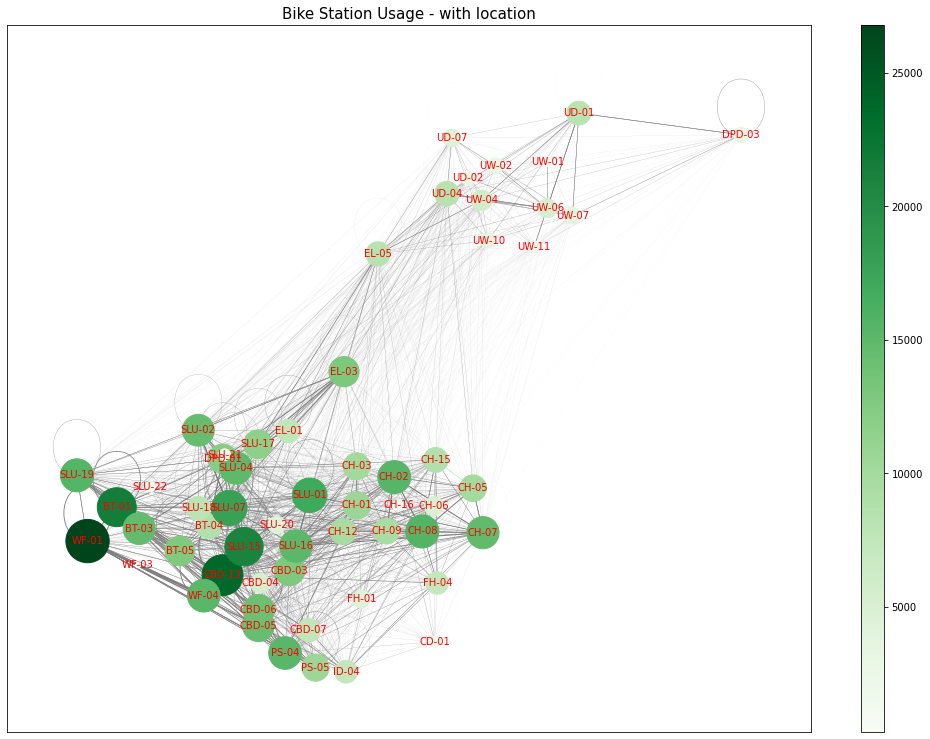

In [20]:
# 3 years aggregate
plotnetworkgraph_loc(G_allyear)

## 2.1 Degree centrality

In [21]:
stationid=[]
degree=[]
for node in G_allyear:
    stationid.append(node)
    degree.append(G_allyear.degree(node, weight='nbr_of_trips'))

degree_dist_list = list (zip(stationid,degree))
degree_dist = pd.DataFrame(degree_dist_list, columns=['station_id','degree'])
degree_dist.sort_values(by='degree',ascending=False) 

station_id  degree
54      WF-01   26790
9      CBD-13   23833
0       BT-01   21671
35     SLU-15   20955
34     SLU-07   17838
31     SLU-01   17053
17      CH-08   15664
39     SLU-19   15553
12      CH-02   15486
56      WF-04   15288
29      PS-04   15231
36     SLU-16   15174
33     SLU-04   14978
16      CH-07   14798
1       BT-03   14625
32     SLU-02   14432
6      CBD-05   14339
7      CBD-06   14002
24      EL-03   13021
4      CBD-03   12823
3       BT-05   12636
22     DPD-01   12129
37     SLU-17   11784
11      CH-01   10686
30      PS-05   10612
13      CH-03   10193
14      CH-05   10069
19      CH-12    9549
18      CH-09    9441
2       BT-04    8750
20      CH-15    8741
45      UD-04    8437
25      EL-05    8359
43      UD-01    8093
38     SLU-18    8074
23      EL-01    7641
8      CBD-07    7587
28      ID-04    7343
27      FH-04    7153
49      UW-04    5953
5      CBD-04    5512
50      UW-06    5254
15      CH-06    5070
26      FH-01    4552
46      UD-07    4361
40     SLU-20    4278
51      UW-07    3898
48      UW-02    3415
52      UW-10    3354
57     DPD-03    3210
44      UD-02    2898
53      UW-11    2101
41     SLU-21    2010
21      CH-16    1930
10      CD-01    1826
42     SLU-22    1490
47      UW-01    1396
55      WF-03     327

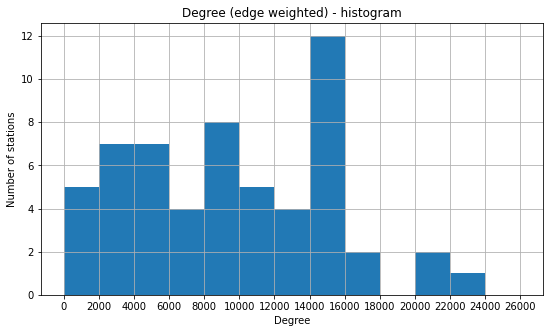

In [22]:
degree_dist.hist(column='degree', alpha=0.99, figsize=(9,5), bins=range(0, 27001, 2000))
plt.title("Degree (edge weighted) - histogram")
plt.xlabel("Degree", fontsize = 10)
plt.xticks(np.arange(0,27001,2000))
plt.ylabel("Number of stations", fontsize = 10)
plt.show()

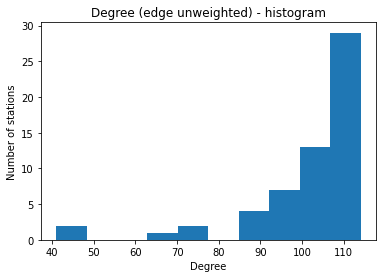

In [23]:
# degree distribution - without weighted edge
plt.hist([node[1] for node in list(G_allyear.degree())])
plt.title("Degree (edge unweighted) - histogram")
plt.xlabel("Degree", fontsize = 10)
plt.ylabel("Number of stations", fontsize = 10)
plt.grid
plt.show()

# 3. Exploratory data analysis

In [24]:
# Drop features
trip.drop(['from_exists', 'to_exists'], axis=1, inplace=True)

In [25]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286833 entries, 0 to 286856
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            286833 non-null  int64         
 1   starttime          286833 non-null  datetime64[ns]
 2   stoptime           286833 non-null  object        
 3   bikeid             286833 non-null  object        
 4   tripduration       286833 non-null  float64       
 5   from_station_name  286833 non-null  object        
 6   to_station_name    286833 non-null  object        
 7   from_station_id    286833 non-null  object        
 8   to_station_id      286833 non-null  object        
 9   usertype           286833 non-null  object        
 10  gender             181540 non-null  object        
 11  birthyear          181536 non-null  float64       
 12  year               286833 non-null  int64         
 13  month              286833 non-null  object  

## 3.1 Riders user-type

<AxesSubplot:ylabel='trip_id'>

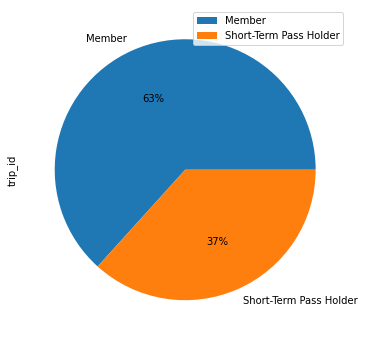

In [26]:
trip.groupby(['usertype']).count().plot(kind='pie', y='trip_id', autopct='%1.0f%%', figsize=(8,6))

## 3.2 Ridership over the operation period

<bound method _AxesBase.grid of <AxesSubplot:title={'center':'Aggregate trip duration by month - different usertype'}, xlabel='month', ylabel='Duration in minutes'>>

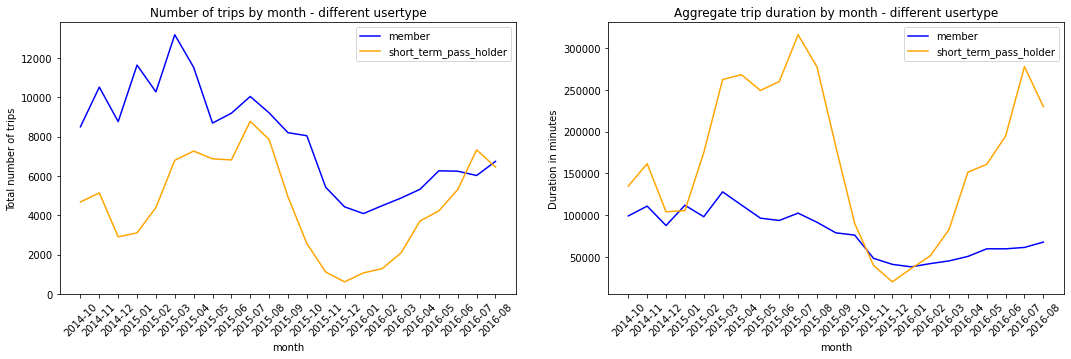

In [27]:
trippivot_mo = trip.pivot_table(index=['month'], columns=['usertype'], values=['trip_id'], aggfunc='count')
trippivot_mo = trippivot_mo.set_axis(['member', 'short_term_pass_holder'], axis=1, inplace=False)

trippivot_min = trip.pivot_table(index=['month'], columns=['usertype'], values=['duration_minutes'], aggfunc='sum')
trippivot_min = trippivot_min.set_axis(['member', 'short_term_pass_holder'], axis=1, inplace=False)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,5),sharey=False)
ax1.plot(trippivot_mo.index, trippivot_mo.member, color='blue', label='member')
ax1.plot(trippivot_mo.index, trippivot_mo.short_term_pass_holder, color='orange', label='short_term_pass_holder')
ax1.legend(loc="upper right")
ax1.set_xlabel("month")
ax1.set_ylabel("Total number of trips")
ax1.tick_params('x',labelrotation=45)
ax1.set_title("Number of trips by month - different usertype")
ax1.grid

ax2.plot(trippivot_min.index, trippivot_min.member, color='blue', label='member')
ax2.plot(trippivot_min.index, trippivot_min.short_term_pass_holder, color='orange', label='short_term_pass_holder')
ax2.legend(loc="upper right")
ax2.set_xlabel("month")
ax2.set_ylabel("Duration in minutes")
ax2.tick_params('x',labelrotation=45)
ax2.set_title("Aggregate trip duration by month - different usertype")
ax2.grid

## 3.3 Trip duration of members vs short-term pass holders

In [28]:
trip_member = trip.loc[trip['usertype'] == 'Member']
trip_passholder = trip.loc[trip['usertype'] == 'Short-Term Pass Holder']

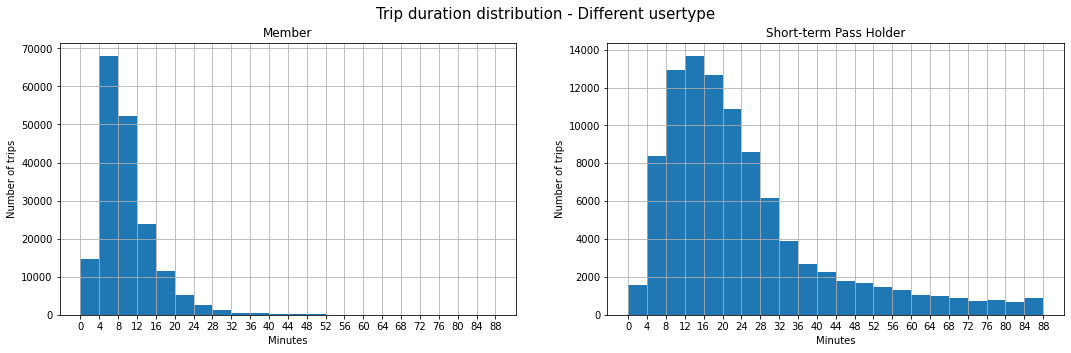

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5),sharey=False)
fig.suptitle('Trip duration distribution - Different usertype', fontsize=15)

ax1.hist(trip_member['duration_minutes'], bins=range(0, 92, 4))
ax1.set_xlabel("Minutes", fontsize = 10)
ax1.set_xticks(np.arange(0,92,4))
ax1.set_ylabel("Number of trips", fontsize = 10)
ax1.set_title("Member", fontsize = 12)
ax1.grid()

ax2.hist(trip_passholder['duration_minutes'], bins=range(0, 92, 4))
ax2.set_xlabel("Minutes", fontsize = 10)
ax2.set_ylabel("Number of trips", fontsize = 10)
ax2.set_xticks(np.arange(0,92,4))
ax2.set_title("Short-term Pass Holder", fontsize = 12)
ax2.grid()

## 3.4 Trip duration of weekday vs weekend

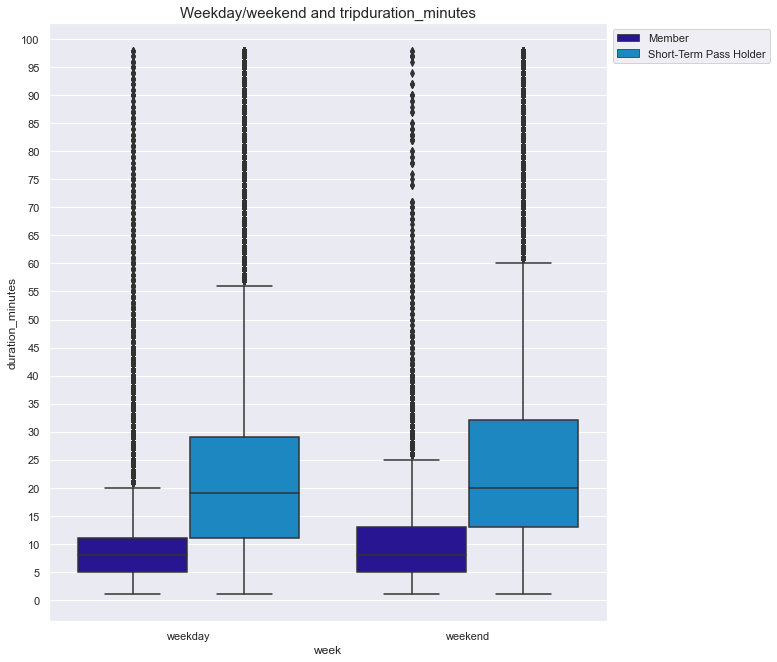

In [30]:
upper_limit = trip['duration_minutes'].quantile(0.97) #set a upper limit to 99th percentile for better plot display
tripx = trip[(trip['duration_minutes'] <= upper_limit)]

# plot box plots
plt.figure(figsize=(10,11))
sns.set(palette='nipy_spectral', font_scale=1)
s = sns.boxplot(x='week',y='duration_minutes', hue='usertype', data=tripx)
s.set_yticks(np.arange(0,101,5))
plt.title('Weekday/weekend and tripduration_minutes', fontsize = 15)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

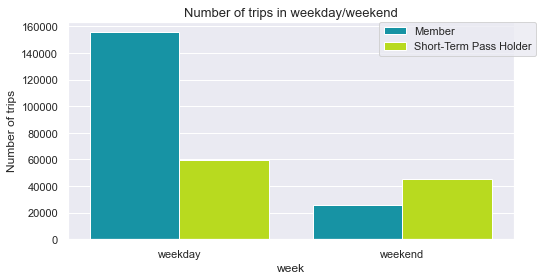

In [31]:
# plot number of trips in weekday/weekend
plt.figure(figsize=(8,4))
ax = sns.countplot(x='week', hue='usertype', data=trip, palette='nipy_spectral')
plt.ylabel("Number of trips", fontsize = 12)
plt.title('Number of trips in weekday/weekend', fontsize = 13)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.show()

## 3.5 Pickup hour of members vs short-term pas holders

In [32]:
trippivot_pick3 = trip_member.pivot_table(index=['pickup_hour'], columns=['week'], values=['trip_id'], aggfunc='count')
trippivot_pick3 = trippivot_pick3.set_axis(['weekday', 'weekend'], axis=1, inplace=False)

trippivot_pick4 = trip_passholder.pivot_table(index=['pickup_hour'], columns=['week'], values=['trip_id'], aggfunc='count')
trippivot_pick4 = trippivot_pick4.set_axis(['weekday', 'weekend'], axis=1, inplace=False)

<bound method _AxesBase.grid of <AxesSubplot:title={'center':'Short-Term Pass Holder user'}, xlabel='Pickup hour'>>

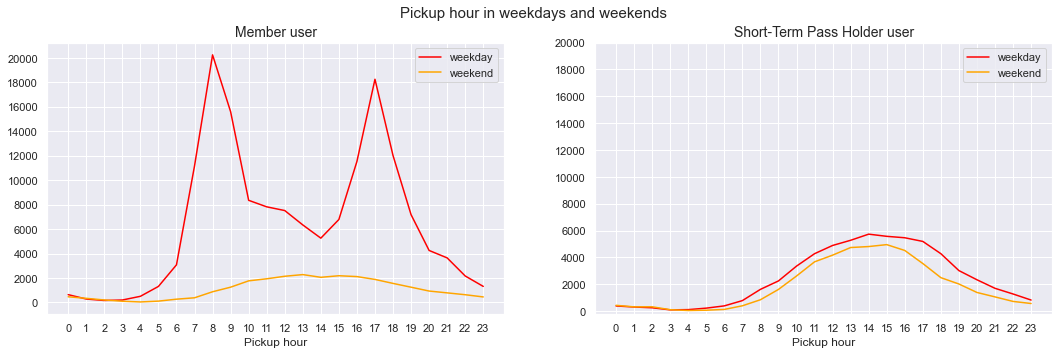

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5),sharey=False)
fig.suptitle('Pickup hour in weekdays and weekends', fontsize=15)

ax1.plot(trippivot_pick3.index, trippivot_pick3.weekday, color='red', label='weekday')
ax1.plot(trippivot_pick3.index, trippivot_pick3.weekend, color='orange', label='weekend')
ax1.set_xlabel("Pickup hour")
ax1.set_xticks(np.arange(0,24,1))
ax1.set_yticks(np.arange(0,20001,2000))
ax1.legend(loc="upper right")
ax1.set_title("Member user", fontsize=14)
ax1.grid

ax2.plot(trippivot_pick4.index, trippivot_pick4.weekday, color='red', label='weekday')
ax2.plot(trippivot_pick4.index, trippivot_pick4.weekend, color='orange', label='weekend')
ax2.set_xlabel("Pickup hour")
ax2.set_xticks(np.arange(0,24,1))
ax2.set_yticks(np.arange(0,20001,2000))
ax2.legend(loc="upper right")
ax2.set_title("Short-Term Pass Holder user", fontsize=14)
ax2.grid

## 3.6 Hotspots for members and short-term passholders

In [34]:
# Add a column for weight edge plotting later, based on nbr_of_trips. This is for formatting the edge width for better visual.
def add_col_adj_nbr_of_trips_revised(df):
    df['adj_nbr_of_trips'] = df['nbr_of_trips']/100

In [35]:
def centralityDegree_weighted_func1(G, title):
    # Figure
    fig, ax = plt.subplots(figsize=(18,12))

    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = [degree[i] for i in G.nodes()]

    # for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')  
    
    # for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))
    
    # Color scale
    cmap=plt.cm.Greens
    #vmin = min(node_color)
    #vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=18500))
    sm._A = []
    plt.colorbar(sm, aspect=30)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=node_color,cmap="Greens", vmin=0, vmax=18500, alpha=1, node_size= [v*70 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='grey', style ="solid", alpha=1, arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='red')

    # Labeling Axes
    ax.set_title('Bike Station Weighted Degree Centrality - ' + str(title), fontdict={"fontsize":18}, pad = 15)
    ax.axis('off')

In [36]:
xx = trip_member.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
yy = trip_passholder.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

for u in [xx,yy]:
    add_col_adj_nbr_of_trips(u)

In [37]:
# form network of trips with member and short-term pass holder
gxx = nx.from_pandas_edgelist(df=xx, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(gxx)
gyy = nx.from_pandas_edgelist(df=yy, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(gyy)

DiGraph with 58 nodes and 2550 edges
DiGraph with 58 nodes and 2774 edges


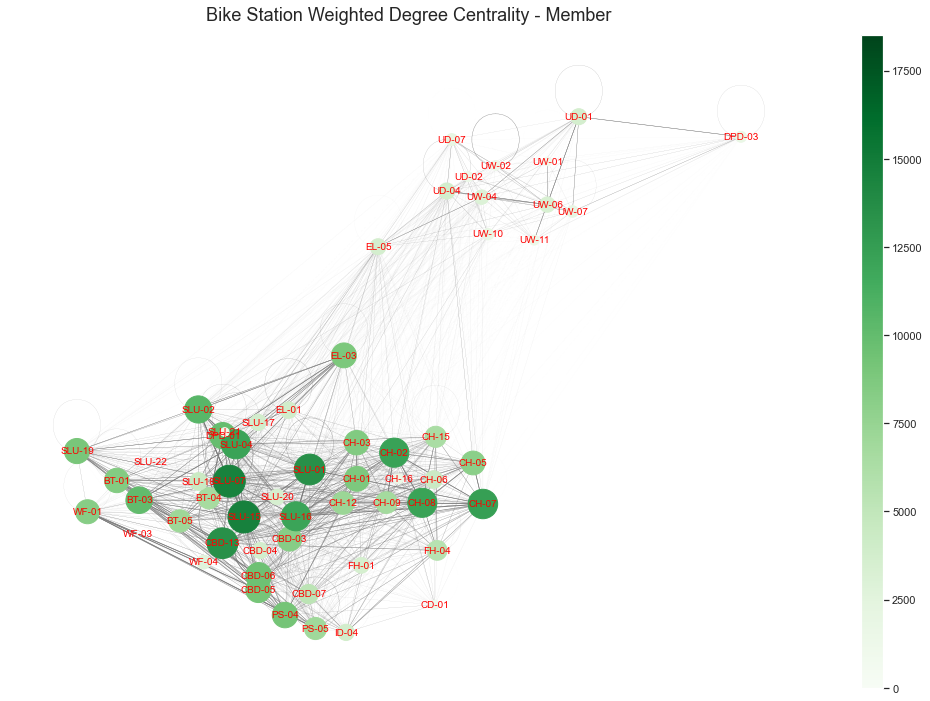

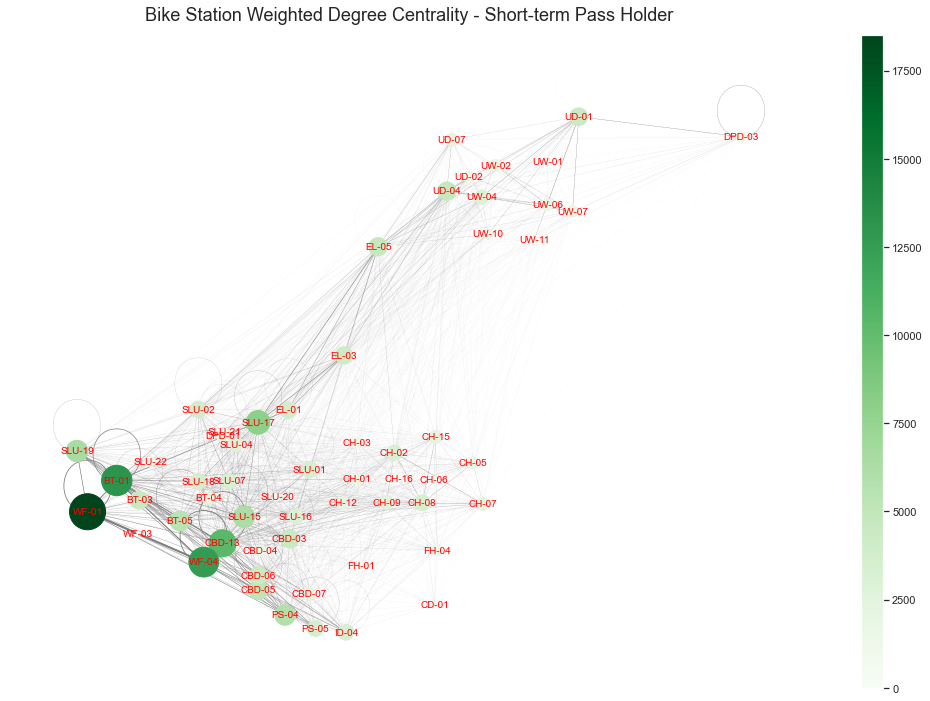

In [38]:
centralityDegree_weighted_func1(gxx,'Member')
centralityDegree_weighted_func1(gyy, 'Short-term Pass Holder')

In [39]:
stationid=[]
degree=[]
for node in gyy:
    stationid.append(node)
    degree.append(gyy.degree(node, weight='nbr_of_trips'))

degree_dist_list = list (zip(stationid,degree))
degree_dist = pd.DataFrame(degree_dist_list, columns=['station_id','degree'])
degree_dist.sort_values(by='degree',ascending=False).iloc[0:5]

station_id  degree
54      WF-01   18548
0       BT-01   13168
56      WF-04   12614
9      CBD-13   10372
37     SLU-17    8017

In [40]:
# list out top 5 stations in terms of degree and addresses
degree_dist1 = pd.merge(degree_dist, station, on = ['station_id'])
degree_dist1[['station_id', 'degree', 'name', 'install_dockcount']].sort_values(by='degree',ascending=False).iloc[0:5]

station_id  degree                                               name  \
54      WF-01   18548                    Pier 69 / Alaskan Way & Clay St   
0       BT-01   13168                                 3rd Ave & Broad St   
56      WF-04   12614  Seattle Aquarium / Alaskan Way S & Elliott Bay...   
9      CBD-13   10372                                  2nd Ave & Pine St   
37     SLU-17    8017          Lake Union Park / Valley St & Boren Ave N   

    install_dockcount  
54                 18  
0                  18  
56                 18  
9                  18  
37                 18

## 3.7 Hotspots for members and short-term pass holders - temporal analysis

In [41]:
trip10140315 = trip.loc[trip.month.isin(['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'])]
trip04151015 = trip.loc[trip.month.isin(['2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09'])]
trip04160816 = trip.loc[trip.month.isin(['2016-04', '2016-05', '2016-06', '2016-07', '2016-08'])]

trip10140315member = trip10140315.loc[trip10140315.usertype.isin(['Member'])]
trip10140315pass = trip10140315.loc[trip10140315.usertype.isin(['Short-Term Pass Holder'])]

trip04151015member = trip04151015.loc[trip04151015.usertype.isin(['Member'])]
trip04151015pass = trip04151015.loc[trip04151015.usertype.isin(['Short-Term Pass Holder'])]

trip04160816member = trip04160816.loc[trip04160816.usertype.isin(['Member'])]
trip04160816pass = trip04160816.loc[trip04160816.usertype.isin(['Short-Term Pass Holder'])]

In [42]:
b = trip10140315.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
c = trip04151015.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
j = trip04160816.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

d = trip10140315member.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
e = trip10140315pass.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

f = trip04151015member.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
g = trip04151015pass.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

h = trip04160816member.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
i = trip04160816pass.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

for u in [b,c,d,e,f,g,h,i,j]:
    add_col_adj_nbr_of_trips_revised(u)

In [43]:
g1 = nx.from_pandas_edgelist(df=b, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g1)
g2 = nx.from_pandas_edgelist(df=c, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g2)
g3 = nx.from_pandas_edgelist(df=d, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g3)
g4 = nx.from_pandas_edgelist(df=e, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g4)
g5 = nx.from_pandas_edgelist(df=f, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g5)
g6 = nx.from_pandas_edgelist(df=g, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g6)
g7 = nx.from_pandas_edgelist(df=h, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g7)
g8 = nx.from_pandas_edgelist(df=i, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g8)
g9 = nx.from_pandas_edgelist(df=j, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(g9)

DiGraph with 50 nodes and 1914 edges
DiGraph with 54 nodes and 2380 edges
DiGraph with 50 nodes and 1710 edges
DiGraph with 50 nodes and 1595 edges
DiGraph with 54 nodes and 2019 edges
DiGraph with 54 nodes and 2206 edges
DiGraph with 56 nodes and 1917 edges
DiGraph with 56 nodes and 2201 edges
DiGraph with 56 nodes and 2440 edges


In [44]:
def centralityDegree_weighted_func2(G, title):
    # Figure
    fig, ax = plt.subplots(figsize=(18,12))

    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = [degree[i] for i in G.nodes()]

    # for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')  
    
    # for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))
    
    # Color scale
    cmap=plt.cm.Greens
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, aspect=30)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=node_color,cmap="Greens", vmin=vmin, vmax=vmax, alpha=1, node_size= [v*10 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='grey', style ="dotted", alpha=0.8, arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='red')

    # Labeling Axes
    ax.set_title('Bike Station Weighted Degree Centrality- ' + str(title), fontdict={"fontsize":18}, pad = 15)
    ax.axis('off')

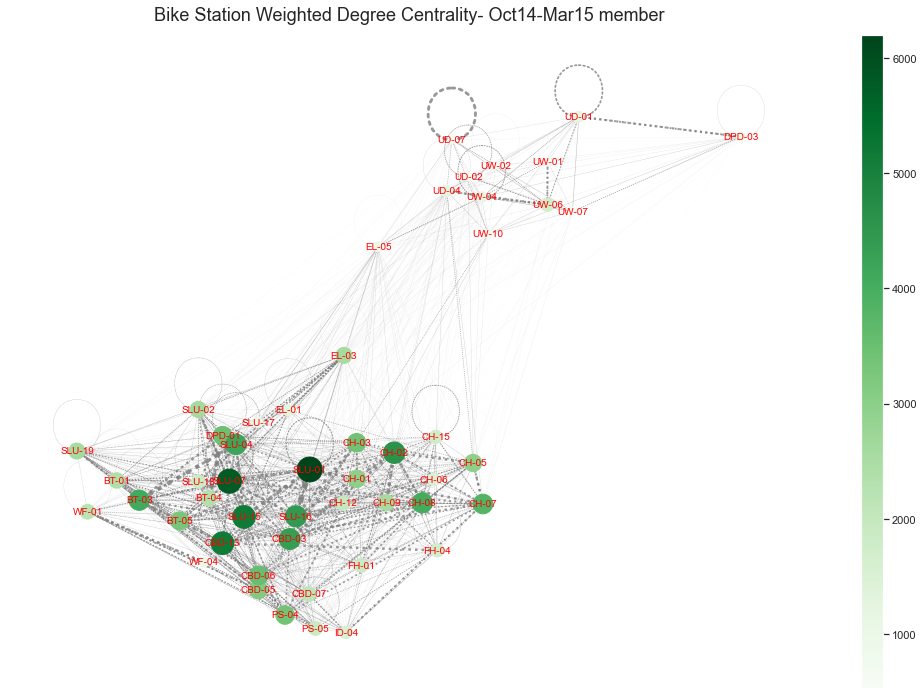

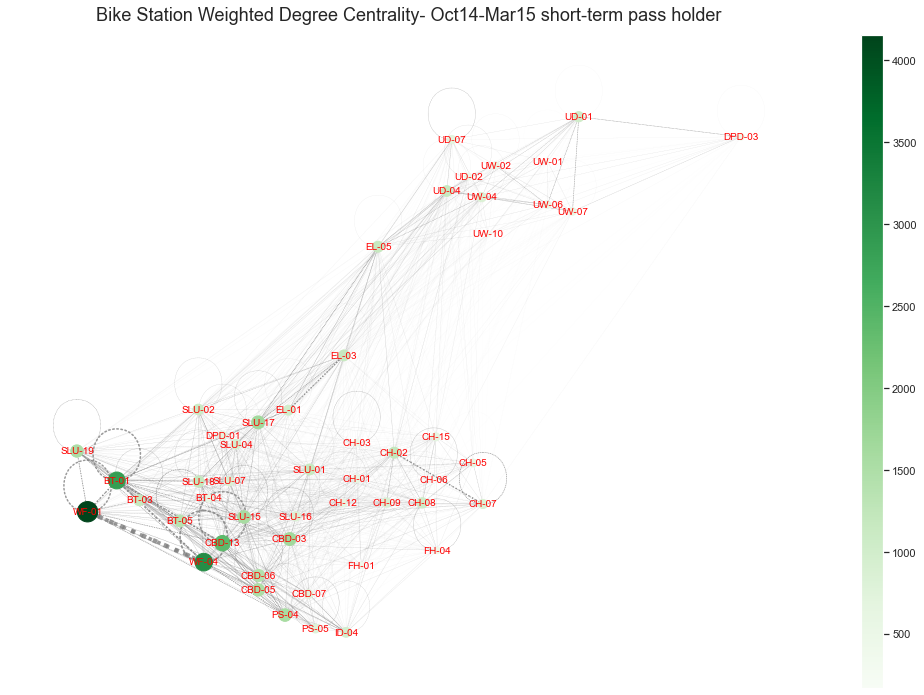

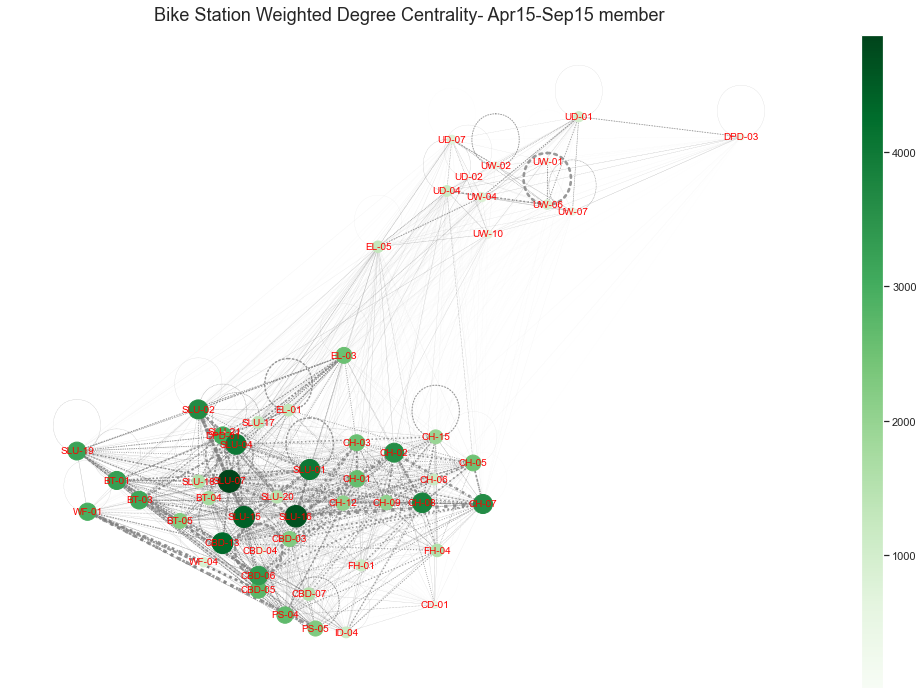

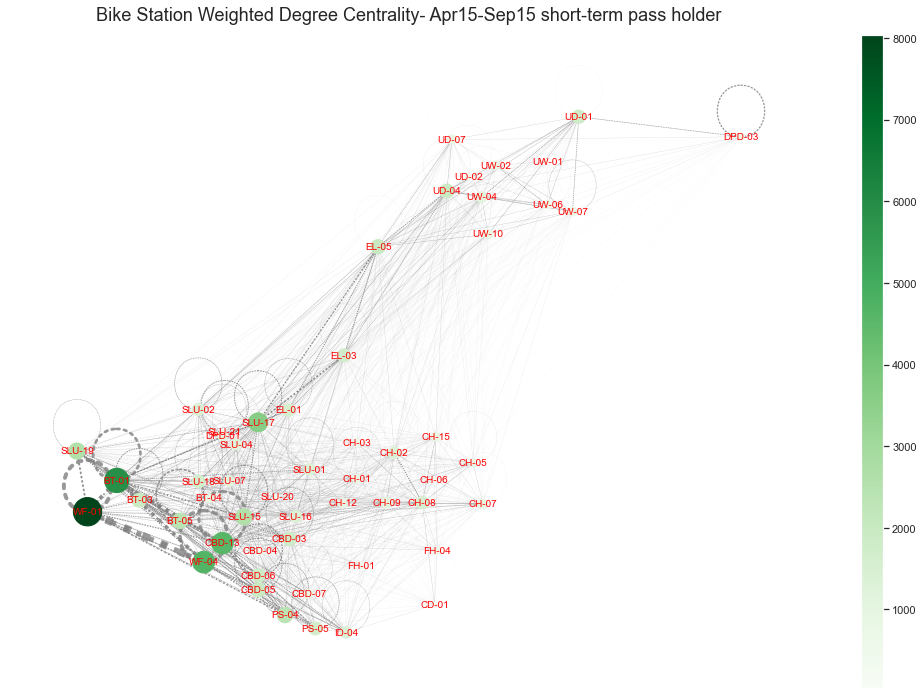

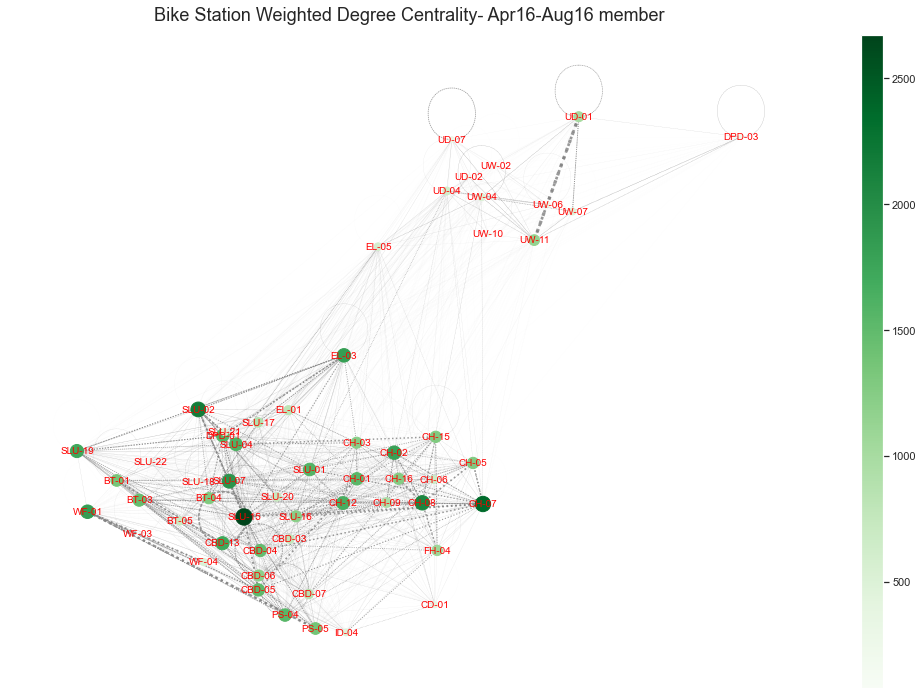

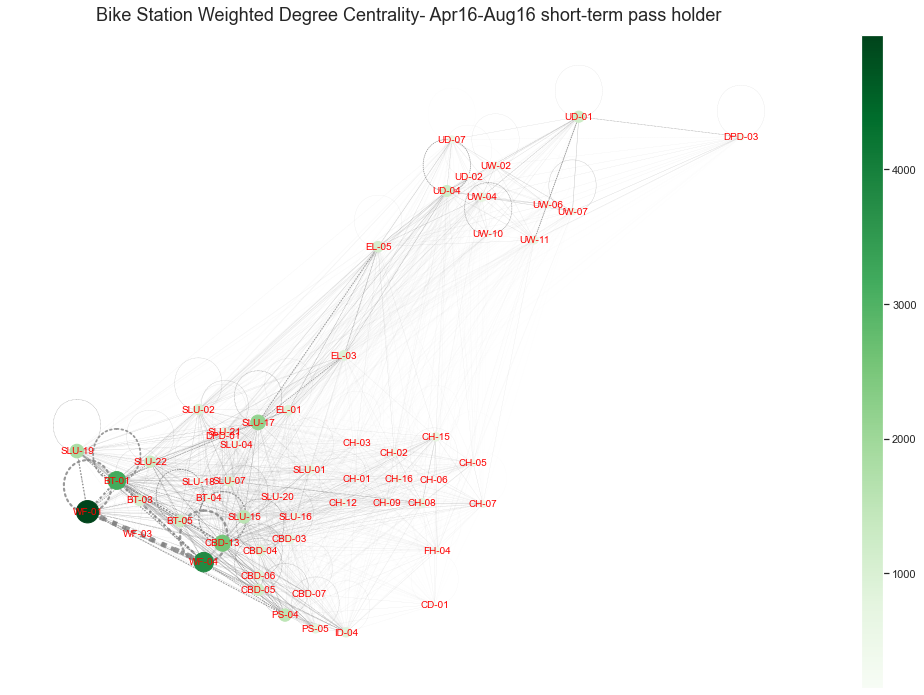

In [45]:
#graphlist = [g1,g3,g4,g2,g5,g6,g9,g7,g8]
#titlelist = ['Oct14-Mar15 all', 'Oct14-Mar15 member', 'Oct14-Mar15 short-term pass holder', 
             #'Apr15-Sep15 all', 'Apr15-Sep15 member', 'Apr15-Sep15 short-term pass holder', 
            #'Apr16-Aug16 all', 'Apr16-Aug16 member','Apr16-Aug16 short-term pass holder']

graphlist = [g3,g4,g5,g6,g7,g8]
titlelist = ['Oct14-Mar15 member', 'Oct14-Mar15 short-term pass holder', 
             'Apr15-Sep15 member', 'Apr15-Sep15 short-term pass holder', 
            'Apr16-Aug16 member','Apr16-Aug16 short-term pass holder']

# degree centrality - edge weighted
for g,t in zip(graphlist, titlelist):
    centralityDegree_weighted_func2(g,t)

# 4. Weather and ridership

In [46]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        689 non-null    object 
 1   Max_Temperature_F           689 non-null    int64  
 2   Mean_Temperature_F          688 non-null    float64
 3   Min_TemperatureF            689 non-null    int64  
 4   Max_Dew_Point_F             689 non-null    int64  
 5   MeanDew_Point_F             689 non-null    int64  
 6   Min_Dewpoint_F              689 non-null    int64  
 7   Max_Humidity                689 non-null    int64  
 8   Mean_Humidity               689 non-null    int64  
 9   Min_Humidity                689 non-null    int64  
 10  Max_Sea_Level_Pressure_In   689 non-null    float64
 11  Mean_Sea_Level_Pressure_In  689 non-null    float64
 12  Min_Sea_Level_Pressure_In   689 non-null    float64
 13  Max_Visibility_Miles        689 non

In [47]:
# % null value in each column
round(weather.isnull().sum() / weather.shape[0] * 100.00,2)

Date                           0.00
Max_Temperature_F              0.00
Mean_Temperature_F             0.15
Min_TemperatureF               0.00
Max_Dew_Point_F                0.00
MeanDew_Point_F                0.00
Min_Dewpoint_F                 0.00
Max_Humidity                   0.00
Mean_Humidity                  0.00
Min_Humidity                   0.00
Max_Sea_Level_Pressure_In      0.00
Mean_Sea_Level_Pressure_In     0.00
Min_Sea_Level_Pressure_In      0.00
Max_Visibility_Miles           0.00
Mean_Visibility_Miles          0.00
Min_Visibility_Miles           0.00
Max_Wind_Speed_MPH             0.00
Mean_Wind_Speed_MPH            0.00
Max_Gust_Speed_MPH            26.85
Precipitation_In               0.00
Events                        52.39
dtype: float64

In [48]:
# Convert dates from object to date type
weather['Date']=pd.to_datetime(weather['Date'])

<bound method _AxesBase.grid of <AxesSubplot:title={'center':'Mean temperature by month'}, xlabel='month'>>

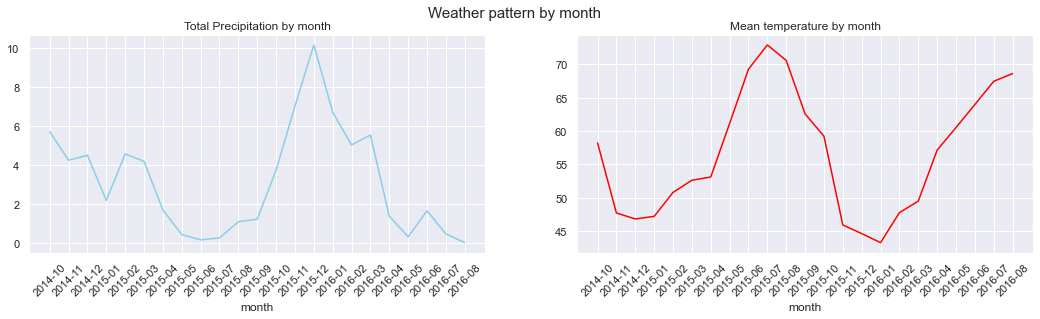

In [49]:
weather['month'] = weather['Date'].dt.strftime('%Y-%m')

month_rain = weather.pivot_table(index=['month'], values=['Precipitation_In'], aggfunc='sum')
month_temp = weather.pivot_table(index=['month'], values=['Mean_Temperature_F'], aggfunc='mean')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4),sharey=False)
fig.suptitle('Weather pattern by month', fontsize=15)

ax1.plot(month_rain.index, month_rain.Precipitation_In, color='skyblue')
ax1.set_xlabel("month")
ax1.tick_params('x',labelrotation=45)
ax1.set_title("Total Precipitation by month")
ax1.grid

ax2.plot(month_rain.index, month_temp.Mean_Temperature_F, color='red')
ax2.set_xlabel("month")
ax2.tick_params('x',labelrotation=45)
ax2.set_title("Mean temperature by month")
ax2.grid


In [50]:
# Set up table on the number of trips between stations for 3 years aggregate
byday = trip.groupby(['date']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
byday.head()

date  nbr_of_trips
0 2014-10-13           818
1 2014-10-14           982
2 2014-10-15           626
3 2014-10-16           790
4 2014-10-17           588

In [51]:
# merge trip and weather
df = byday.merge(weather, left_on='date', right_on='Date', how='left')
df.head()

date  nbr_of_trips       Date  Max_Temperature_F  Mean_Temperature_F  \
0 2014-10-13           818 2014-10-13                 71                62.0   
1 2014-10-14           982 2014-10-14                 63                59.0   
2 2014-10-15           626 2014-10-15                 62                58.0   
3 2014-10-16           790 2014-10-16                 71                61.0   
4 2014-10-17           588 2014-10-17                 64                60.0   

   Min_TemperatureF  Max_Dew_Point_F  MeanDew_Point_F  Min_Dewpoint_F  \
0                54               55               51              46   
1                55               52               51              50   
2                54               53               50              46   
3                52               49               46              42   
4                57               55               51              41   

   Max_Humidity  ...  Min_Sea_Level_Pressure_In  Max_Visibility_Miles  \
0            87  ...                      29.65                    10   
1            88  ...                      29.54                    10   
2            87  ...                      29.51                    10   
3            83  ...                      29.81                    10   
4            87  ...                      29.73                    10   

   Mean_Visibility_Miles  Min_Visibility_Miles  Max_Wind_Speed_MPH  \
0                     10                     4                  13   
1                      9                     3                  10   
2                      9                     3                  18   
3                     10                    10                   9   
4                     10                     6                   8   

   Mean_Wind_Speed_MPH  Max_Gust_Speed_MPH  Precipitation_In  Events    month  
0                    4                  21              0.00    Rain  2014-10  
1                    5                  17              0.11    Rain  2014-10  
2                    7                  25              0.45    Rain  2014-10  
3                    4                   -              0.00    Rain  2014-10  
4                    3                   -              0.14    Rain  2014-10  

[5 rows x 24 columns]

In [52]:
df.shape

(689, 24)

In [53]:
# Check number of NaN values in each column
for column in df.columns:
    if df[column].isnull().any(): #if any NaN in the column
        print(f"{column}",df[column].isnull().sum())    #print the column name then the sum of number of NaN values

Mean_Temperature_F 1
Max_Gust_Speed_MPH 185
Events 361


In [54]:
# Count and list number of unique values in specific column
df['Events'].value_counts(dropna=False)

NaN                    361
Rain                   287
Fog                     16
Fog , Rain               7
Fog-Rain                 6
Rain-Thunderstorm        4
Rain , Thunderstorm      3
Snow                     2
Rain-Snow                2
Rain , Snow              1
Name: Events, dtype: int64

In [55]:
# Replace the minor categories with Rain
df['Events'] = df['Events'].replace(np.nan, 'No_event')
df['Events'].replace(['Rain , Snow','Fog','Fog , Rain','Rain , Thunderstorm','Fog-Rain','Snow','Rain-Thunderstorm','Rain-Snow'],
                     'Rain',inplace=True)
df['Events'].value_counts(dropna=False)

No_event    361
Rain        328
Name: Events, dtype: int64

In [56]:
# Drop the column with significant null values
df.drop(['Max_Gust_Speed_MPH'], axis=1, inplace=True)

In [57]:
# Replace the single null value with mean of the column
df['Mean_Temperature_F'] = df['Mean_Temperature_F'].fillna(df['Mean_Temperature_F'].mean())

In [58]:
selectedfeatures = ['Mean_Temperature_F','MeanDew_Point_F','Mean_Humidity','Mean_Wind_Speed_MPH','Mean_Sea_Level_Pressure_In', 
        'Mean_Visibility_Miles','Precipitation_In']

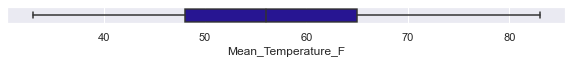

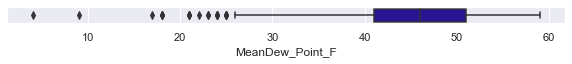

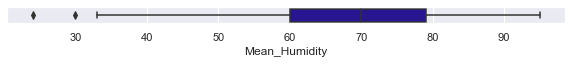

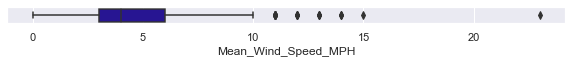

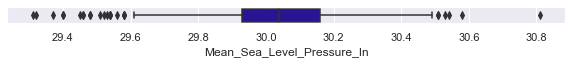

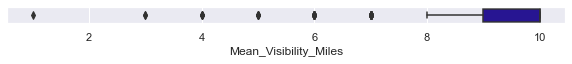

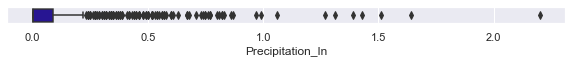

In [59]:
# Plot all numerical features in box plots - horizontal
for i in selectedfeatures:
    plt.figure(figsize=(10,0.3))
    sns.boxplot(x=i, data=df)

plt.show()

## 4.1 Correlations between different weather features

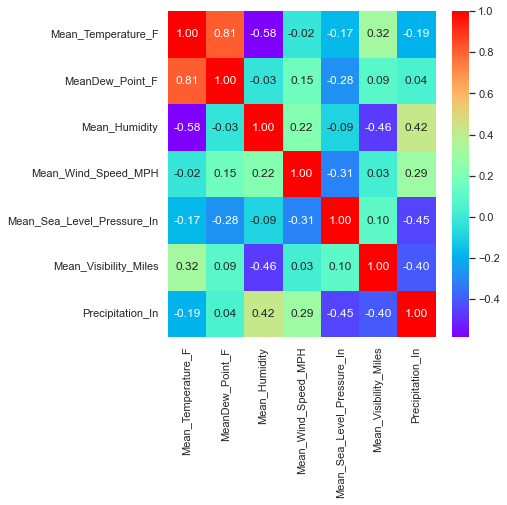

In [60]:
# Corr matrix
df_selected_feat = df[selectedfeatures]

plt.figure(figsize=(6,6))
sns.heatmap(df_selected_feat.corr(),annot=True,fmt='.2f',cmap='rainbow', )
plt.show()

In [61]:
# one-hot encoding
df = pd.get_dummies(df, columns = ['Events'], drop_first=True)

In [62]:
# Count and list number of unique values in specific column
df['Events_Rain'].value_counts(dropna=False)

0    361
1    328
Name: Events_Rain, dtype: int64

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 689 entries, 0 to 688
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        689 non-null    datetime64[ns]
 1   nbr_of_trips                689 non-null    int64         
 2   Date                        689 non-null    datetime64[ns]
 3   Max_Temperature_F           689 non-null    int64         
 4   Mean_Temperature_F          689 non-null    float64       
 5   Min_TemperatureF            689 non-null    int64         
 6   Max_Dew_Point_F             689 non-null    int64         
 7   MeanDew_Point_F             689 non-null    int64         
 8   Min_Dewpoint_F              689 non-null    int64         
 9   Max_Humidity                689 non-null    int64         
 10  Mean_Humidity               689 non-null    int64         
 11  Min_Humidity                689 non-null    int64         

## 4.2 Correlation between weather and ridership

In [64]:
import statsmodels.api as sm

In [65]:
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)

model3 = sm.OLS(y, x).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     88.71
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.68e-48
Time:                        18:26:29   Log-Likelihood:                -4483.8
No. Observations:                 689   AIC:                             8976.
Df Residuals:                     685   BIC:                             8994.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 136.0568     36.593      3.718      0.000      64.209     207.905
Mean_Temperature_F      6.4203      0.608     10.553      0.000       5.226       7.615
Mean_Wind_Speed_MPH   -13.5448      2.336     -5.798      0.000     -18.132      -8.958
Precipitation_In     -193.3012     28.096     -6.880      0.000    -248.465    -138.137
==============================================================================
Omnibus:                      121.994   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.113
Skew:                           1.086   Prob(JB):                     6.44e-46
Kurtosis:                       4.592   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Visibility_Miles', 'Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)

model4 = sm.OLS(y, x).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     66.62
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.31e-47
Time:                        18:26:29   Log-Likelihood:                -4483.5
No. Observations:                 689   AIC:                             8977.
Df Residuals:                     684   BIC:                             9000.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   100.9760     59.765      1.690      0.092     -16.369     218.321
Mean_Temperature_F        6.2945      0.632      9.964      0.000       5.054       7.535
Mean_Visibility_Miles     4.5157      6.081      0.743      0.458      -7.424      16.456
Mean_Wind_Speed_MPH     -13.8316      2.369     -5.840      0.000     -18.482      -9.181
Precipitation_In       -184.2898     30.613     -6.020      0.000    -244.396    -124.183
==============================================================================
Omnibus:                      121.350   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.028
Skew:                           1.083   Prob(JB):                     1.83e-45
Kurtosis:                       4.576   Cond. No.                         581.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.3 Which sub-groups are more reilient to weather fluctuation

In [67]:
# define a function for the regular data pre-processing
def data_preprocess(df):
    df = df.merge(weather, left_on='date', right_on='Date', how='left')
    df.drop(['Max_Gust_Speed_MPH'], axis=1, inplace=True)
    df['Mean_Temperature_F'] = df['Mean_Temperature_F'].fillna(df['Mean_Temperature_F'].mean())
    df['Events'] = df['Events'].replace(np.nan, 'No_event')
    df['Events'].replace(['Rain , Snow','Fog','Fog , Rain','Rain , Thunderstorm','Fog-Rain','Snow','Rain-Thunderstorm','Rain-Snow','Rain'],inplace=True)
    df = pd.get_dummies(df, columns = ['Events'], drop_first=True)
    return(df)

### 4.3.1 Member vs Short-term pass holder

In [68]:
trip_mem_stpass = trip.groupby(['usertype','date']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_mem_stpass = data_preprocess(trip_mem_stpass)
trip_mem_stpass.head()

usertype       date  nbr_of_trips       Date  Max_Temperature_F  \
0   Member 2014-10-13           568 2014-10-13                 71   
1   Member 2014-10-14           536 2014-10-14                 63   
2   Member 2014-10-15           424 2014-10-15                 62   
3   Member 2014-10-16           536 2014-10-16                 71   
4   Member 2014-10-17           390 2014-10-17                 64   

   Mean_Temperature_F  Min_TemperatureF  Max_Dew_Point_F  MeanDew_Point_F  \
0                62.0                54               55               51   
1                59.0                55               52               51   
2                58.0                54               53               50   
3                61.0                52               49               46   
4                60.0                57               55               51   

   Min_Dewpoint_F  ...  Mean_Sea_Level_Pressure_In  Min_Sea_Level_Pressure_In  \
0              46  ...                       29.79                      29.65   
1              50  ...                       29.75                      29.54   
2              46  ...                       29.71                      29.51   
3              42  ...                       29.95                      29.81   
4              41  ...                       29.78                      29.73   

   Max_Visibility_Miles  Mean_Visibility_Miles  Min_Visibility_Miles  \
0                    10                     10                     4   
1                    10                      9                     3   
2                    10                      9                     3   
3                    10                     10                    10   
4                    10                     10                     6   

   Max_Wind_Speed_MPH  Mean_Wind_Speed_MPH  Precipitation_In    month  \
0                  13                    4              0.00  2014-10   
1                  10                    5              0.11  2014-10   
2                  18                    7              0.45  2014-10   
3                   9                    4              0.00  2014-10   
4                   8                    3              0.14  2014-10   

   Events_Rain  
0            1  
1            1  
2            1  
3            1  
4            1  

[5 rows x 24 columns]

In [69]:
trip_mem_stpass['usertype'].value_counts()

Member                    689
Short-Term Pass Holder    688
Name: usertype, dtype: int64

#### Member

In [70]:
df = trip_mem_stpass.loc[trip_mem_stpass['usertype'] == 'Member']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     15.97
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           4.82e-10
Time:                        18:26:29   Log-Likelihood:                -4353.2
No. Observations:                 689   AIC:                             8714.
Df Residuals:                     685   BIC:                             8733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 244.7443     30.276      8.084      0.000     185.299     304.189
Mean_Temperature_F      1.0874      0.503      2.160      0.031       0.099       2.076
Mean_Wind_Speed_MPH    -7.3512      1.933     -3.803      0.000     -11.146      -3.556
Precipitation_In      -83.2361     23.246     -3.581      0.000    -128.877     -37.595
==============================================================================
Omnibus:                       31.063   Durbin-Watson:                   0.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.574
Skew:                           0.547   Prob(JB):                     3.11e-08
Kurtosis:                       2.905   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Short-term pass holder

In [71]:
df = trip_mem_stpass.loc[trip_mem_stpass['usertype'] == 'Short-Term Pass Holder']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     105.2
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           5.19e-56
Time:                        18:26:29   Log-Likelihood:                -4163.3
No. Observations:                 688   AIC:                             8335.
Df Residuals:                     684   BIC:                             8353.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -108.0947     23.208     -4.658      0.000    -153.662     -62.527
Mean_Temperature_F      5.3266      0.386     13.812      0.000       4.569       6.084
Mean_Wind_Speed_MPH    -6.2446      1.483     -4.212      0.000      -9.156      -3.333
Precipitation_In     -109.2605     17.854     -6.120      0.000    -144.316     -74.205
==============================================================================
Omnibus:                      288.433   Durbin-Watson:                   1.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1276.705
Skew:                           1.912   Prob(JB):                    5.85e-278
Kurtosis:                       8.469   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.3.2 Different age groups (members only)

In [72]:
# Member only dataframe - as age is missing for all short-term pass holder usertype
trip_member = trip.loc[trip['usertype'] == 'Member']
trip_member.shape

(181540, 22)

In [73]:
# Original shape
trip.shape

(286833, 22)

In [74]:
# Count and list number of unique values in specific column
trip_member['age'].value_counts(dropna=False)

28.0    15998
30.0    10393
27.0     9676
33.0     9187
29.0     9092
        ...  
NaN         4
78.0        2
73.0        2
80.0        1
85.0        1
Name: age, Length: 65, dtype: int64

In [75]:
# Replace the single null value with mean of the column
trip_member['age'] = trip_member['age'].fillna(trip_member['age'].median())

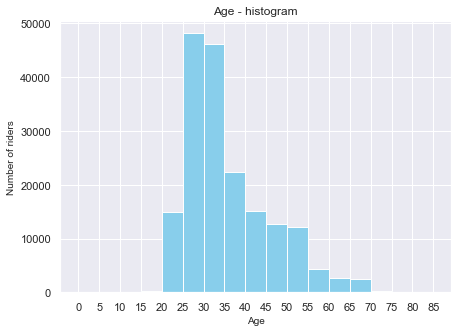

In [76]:
trip_member.hist(column='age', color='skyblue',alpha=0.99, figsize=(7,5), bins=range(0, 90, 5))
plt.title("Age - histogram")
plt.xlabel("Age", fontsize = 10)
plt.xticks(np.arange(0,90,5))
plt.ylabel("Number of riders", fontsize = 10)
plt.show()

In [77]:
# Add a column of age categories
trip_member['age_group'] = pd.cut(
    trip_member['age'], [15,25,30,40,60,90], 
    labels = ['16-25' , '26-30' , '31-40', '41-60','61-90'])
trip_member['age_group'].value_counts(dropna=False)

31-40    61822
26-30    52103
41-60    41291
16-25    21596
61-90     4728
Name: age_group, dtype: int64

In [78]:
trip_member_age = trip_member.groupby(['age_group','date']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_member_age = data_preprocess(trip_member_age)
trip_member_age

age_group       date  nbr_of_trips       Date  Max_Temperature_F  \
0        16-25 2014-10-13            56 2014-10-13                 71   
1        16-25 2014-10-14            64 2014-10-14                 63   
2        16-25 2014-10-15            60 2014-10-15                 62   
3        16-25 2014-10-16            60 2014-10-16                 71   
4        16-25 2014-10-17            52 2014-10-17                 64   
...        ...        ...           ...        ...                ...   
3440     61-90 2016-08-27             1 2016-08-27                 72   
3441     61-90 2016-08-28             3 2016-08-28                 75   
3442     61-90 2016-08-29             6 2016-08-29                 81   
3443     61-90 2016-08-30             2 2016-08-30                 70   
3444     61-90 2016-08-31             6 2016-08-31                 71   

      Mean_Temperature_F  Min_TemperatureF  Max_Dew_Point_F  MeanDew_Point_F  \
0                   62.0                54               55               51   
1                   59.0                55               52               51   
2                   58.0                54               53               50   
3                   61.0                52               49               46   
4                   60.0                57               55               51   
...                  ...               ...              ...              ...   
3440                66.0                61               57               54   
3441                68.0                59               54               52   
3442                68.0                55               55               53   
3443                64.0                57               55               53   
3444                65.0                59               61               56   

      Min_Dewpoint_F  ...  Mean_Sea_Level_Pressure_In  \
0                 46  ...                       29.79   
1                 50  ...                       29.75   
2                 46  ...                       29.71   
3                 42  ...                       29.95   
4                 41  ...                       29.78   
...              ...  ...                         ...   
3440              50  ...                       29.88   
3441              50  ...                       30.06   
3442              50  ...                       30.02   
3443              52  ...                       30.01   
3444              52  ...                       29.97   

      Min_Sea_Level_Pressure_In  Max_Visibility_Miles  Mean_Visibility_Miles  \
0                         29.65                    10                     10   
1                         29.54                    10                      9   
2                         29.51                    10                      9   
3                         29.81                    10                     10   
4                         29.73                    10                     10   
...                         ...                   ...                    ...   
3440                      29.77                    10                     10   
3441                      30.01                    10                     10   
3442                      29.95                    10                     10   
3443                      29.97                    10                     10   
3444                      29.96                    10                     10   

      Min_Visibility_Miles  Max_Wind_Speed_MPH  Mean_Wind_Speed_MPH  \
0                        4                  13                    4   
1                        3                  10                    5   
2                        3                  18                    7   
3                       10                   9                    4   
4                        6                   8                    3   
...                    ...                 ...                  ...   
3440                    

#### 16-25 age group

In [79]:
df = trip_member_age.loc[trip_member_age['age_group'] == '16-25']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     15.68
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           7.15e-10
Time:                        18:26:30   Log-Likelihood:                -2957.1
No. Observations:                 689   AIC:                             5922.
Df Residuals:                     685   BIC:                             5940.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  21.0136      3.991      5.265      0.000      13.177      28.850
Mean_Temperature_F      0.2667      0.066      4.019      0.000       0.136       0.397
Mean_Wind_Speed_MPH    -0.8489      0.255     -3.332      0.001      -1.349      -0.349
Precipitation_In       -7.8758      3.064     -2.570      0.010     -13.893      -1.859
==============================================================================
Omnibus:                       57.903   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.411
Skew:                           0.762   Prob(JB):                     5.13e-16
Kurtosis:                       3.359   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 26-30 age group

In [80]:
df = trip_member_age.loc[trip_member_age['age_group'] == '26-30']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     12.27
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           7.97e-08
Time:                        18:26:30   Log-Likelihood:                -3520.3
No. Observations:                 689   AIC:                             7049.
Df Residuals:                     685   BIC:                             7067.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  79.0567      9.039      8.746      0.000      61.310      96.804
Mean_Temperature_F      0.1512      0.150      1.006      0.315      -0.144       0.446
Mean_Wind_Speed_MPH    -2.0720      0.577     -3.591      0.000      -3.205      -0.939
Precipitation_In      -22.7943      6.940     -3.285      0.001     -36.420      -9.169
==============================================================================
Omnibus:                       48.547   Durbin-Watson:                   0.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.105
Skew:                           0.695   Prob(JB):                     3.98e-13
Kurtosis:                       3.235   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 31-40 age group

In [81]:
df = trip_member_age.loc[trip_member_age['age_group'] == '31-40']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     16.43
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           2.56e-10
Time:                        18:26:30   Log-Likelihood:                -3602.2
No. Observations:                 689   AIC:                             7212.
Df Residuals:                     685   BIC:                             7231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  80.1809     10.179      7.877      0.000      60.194     100.168
Mean_Temperature_F      0.4235      0.169      2.502      0.013       0.091       0.756
Mean_Wind_Speed_MPH    -2.4970      0.650     -3.842      0.000      -3.773      -1.221
Precipitation_In      -27.1320      7.816     -3.472      0.001     -42.477     -11.787
==============================================================================
Omnibus:                       27.378   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.573
Skew:                           0.496   Prob(JB):                     3.79e-07
Kurtosis:                       3.211   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 41-60 age group

In [82]:
df = trip_member_age.loc[trip_member_age['age_group'] == '41-60']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     13.52
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.40e-08
Time:                        18:26:30   Log-Likelihood:                -3450.4
No. Observations:                 689   AIC:                             6909.
Df Residuals:                     685   BIC:                             6927.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  57.1084      8.167      6.993      0.000      41.074      73.143
Mean_Temperature_F      0.2341      0.136      1.724      0.085      -0.032       0.501
Mean_Wind_Speed_MPH    -1.7435      0.521     -3.344      0.001      -2.767      -0.720
Precipitation_In      -22.3795      6.270     -3.569      0.000     -34.690     -10.069
==============================================================================
Omnibus:                      136.610   Durbin-Watson:                   0.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.456
Skew:                           1.033   Prob(JB):                     6.43e-73
Kurtosis:                       5.704   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 61-90 age group

In [83]:
df = trip_member_age.loc[trip_member_age['age_group'] == '61-90']
y = df['nbr_of_trips']
x = df[['Mean_Temperature_F','Mean_Wind_Speed_MPH','Precipitation_In']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     7.501
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           6.05e-05
Time:                        18:26:30   Log-Likelihood:                -2178.1
No. Observations:                 689   AIC:                             4364.
Df Residuals:                     685   BIC:                             4382.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.3840      1.288      5.731      0.000       4.854       9.914
Mean_Temperature_F      0.0120      0.021      0.559      0.576      -0.030       0.054
Mean_Wind_Speed_MPH    -0.1898      0.082     -2.307      0.021      -0.351      -0.028
Precipitation_In       -3.0545      0.989     -3.088      0.002      -4.997      -1.112
==============================================================================
Omnibus:                      567.967   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22178.217
Skew:                           3.375   Prob(JB):                         0.00
Kurtosis:                      29.962   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 5. Stations net bike inflow / (outflow)

In [84]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         58 non-null     object 
 1   name               58 non-null     object 
 2   lat                58 non-null     float64
 3   long               58 non-null     float64
 4   install_date       58 non-null     object 
 5   install_dockcount  58 non-null     int64  
 6   modification_date  17 non-null     object 
 7   current_dockcount  58 non-null     int64  
 8   decommission_date  4 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


In [85]:
station['dockcount_change'] = station['current_dockcount'] - station['install_dockcount']

In [86]:
station['dockcount_change'].value_counts(dropna=False)

 0     39
-2      4
 2      4
-16     3
-6      2
 4      2
-4      1
 8      1
-20     1
 6      1
Name: dockcount_change, dtype: int64

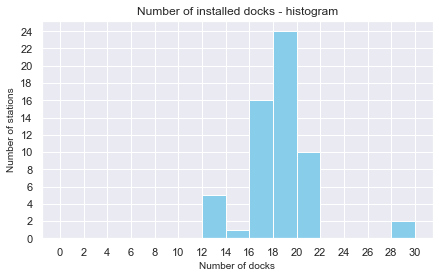

In [87]:
station.hist(column='install_dockcount', color='skyblue',alpha=0.99, figsize=(7,4), bins=range(0, 31, 2))
plt.title("Number of installed docks - histogram")
plt.xlabel("Number of docks", fontsize = 10)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.ylabel("Number of stations", fontsize = 10)
plt.show()

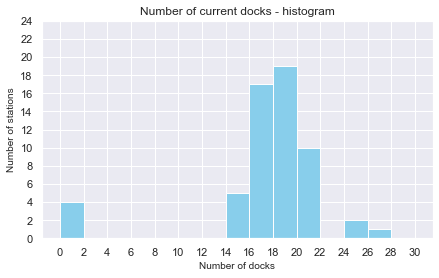

In [88]:
station.hist(column='current_dockcount', color='skyblue',alpha=0.99, figsize=(7,4), bins=range(0, 31, 2))
plt.title("Number of current docks - histogram")
plt.xlabel("Number of docks", fontsize = 10)
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,25,2))
plt.ylabel("Number of stations", fontsize = 10)
plt.show()

## 5.1 Visualise net inflow/outflow on the network

### Oct 2014 to Aug 2016 full period

In [89]:
fromdf = trip.groupby(['date', 'from_station_id'])[['trip_id']].count().reset_index()
todf = trip.groupby(['date','to_station_id'])[['trip_id']].count().reset_index()
fromdf.rename(columns={'trip_id':'countfrom'}, inplace = True)
todf.rename(columns={'trip_id':'countto'}, inplace = True)
    
dffromto = pd.merge(fromdf, todf, left_on = ['from_station_id', 'date'], right_on = ['to_station_id', 'date'], how='outer')
dffromto['from_station_id'] = dffromto['from_station_id'].fillna(dffromto['to_station_id']) # outer join caused NaN, just take the station id from the other column
dffromto['countfrom'] = dffromto['countfrom'].fillna(0)
dffromto['countto'] = dffromto['countto'].fillna(0) # also need to fill the NaN with zeros before computation

dffromto['net_in(out)flow'] = dffromto['countto'] - dffromto['countfrom'] # number of trips incoming - outgoing for each station

df_flow = dffromto.drop(['countfrom', 'to_station_id', 'countto'], axis=1)
df_flow.rename(columns={'from_station_id':'station'}, inplace = True)

df_flow

date station  net_in(out)flow
0     2014-10-13   BT-01             -8.0
1     2014-10-13   BT-03             10.0
2     2014-10-13   BT-04            -20.0
3     2014-10-13   BT-05             10.0
4     2014-10-13  CBD-03              4.0
...          ...     ...              ...
34364 2016-08-29  DPD-03              2.0
34365 2016-08-31   EL-05              1.0
34366 2016-08-31  SLU-21              4.0
34367 2016-08-31   UW-07              1.0
34368 2016-08-31   UW-10              2.0

[34369 rows x 3 columns]

In [90]:
# Set up table on the number of trips between stations for 3 years aggregate
df_flow_gp = df_flow.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()
df_flow_gp 

station  net_in_out_flow
0    BT-01           -197.0
1    BT-03          -1711.0
2    BT-04           -618.0
3    BT-05             96.0
4   CBD-03           1713.0
5   CBD-04            126.0
6   CBD-05           3087.0
7   CBD-06           3076.0
8   CBD-07            331.0
9   CBD-13           3735.0
10   CD-01            -90.0
11   CH-01          -2850.0
12   CH-02          -3792.0
13   CH-03          -2959.0
14   CH-05          -5287.0
15   CH-06          -2602.0
16   CH-07          -7982.0
17   CH-08          -3272.0
18   CH-09          -1955.0
19   CH-12          -1547.0
20   CH-15          -3903.0
21   CH-16           -646.0
22  DPD-01           1807.0
23  DPD-03           -104.0
24   EL-01            481.0
25   EL-03           1527.0
26   EL-05           1069.0
27   FH-01          -2012.0
28   FH-04          -1001.0
29   ID-04           1881.0
30   PS-04           3937.0
31   PS-05           2876.0
32  SLU-01            289.0
33  SLU-02            562.0
34  SLU-04           3632.0
35  SLU-07           3426.0
36  SLU-15            967.0
37  SLU-16           3054.0
38  SLU-17            436.0
39  SLU-18           -962.0
40  SLU-19            581.0
41  SLU-20             20.0
42  SLU-21            284.0
43  SLU-22            -32.0
44   UD-01            525.0
45   UD-02             30.0
46   UD-04           1177.0
47   UD-07           -749.0
48   UW-01           -108.0
49   UW-02           -721.0
50   UW-04            351.0
51   UW-06           -124.0
52   UW-07            202.0
53   UW-10            558.0
54   UW-11            125.0
55   WF-01            682.0
56   WF-03              7.0
57   WF-04           2574.0

In [91]:
min(df_flow_gp['net_in_out_flow'].astype(int).to_list())

-7982

In [92]:
max(df_flow_gp['net_in_out_flow'].astype(int).to_list())

3937

In [93]:
def plot_trip_net_flow(G, dataframe, title):
    
    # Define which netflow dataframe to plot
    df = dataframe
    df = df.set_index('station')
    df = df.reindex(G.nodes())
    
    # Figure
    fig, ax = plt.subplots(figsize=(18,12))

    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = df['net_in_out_flow'].astype(int).to_list()

    # for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')  
    
    # for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))
    
    # Color scale
    cmap=plt.cm.seismic
    vmin = min(node_color)
    vmax = abs(vmin) # balancing the colour bar with middle point at zero
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm,aspect=30)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=df['net_in_out_flow'].astype(int),cmap="seismic", vmin=vmin, vmax=vmax, alpha=1, node_size= [v*70 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='grey', style ="solid", alpha=1, arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='black')

    # Labeling Axes
    ax.set_title('Stations net bike inflow/(outflow) - ' + str(title), fontdict={"fontsize":17}, pad = 15)
    ax.axis('off')

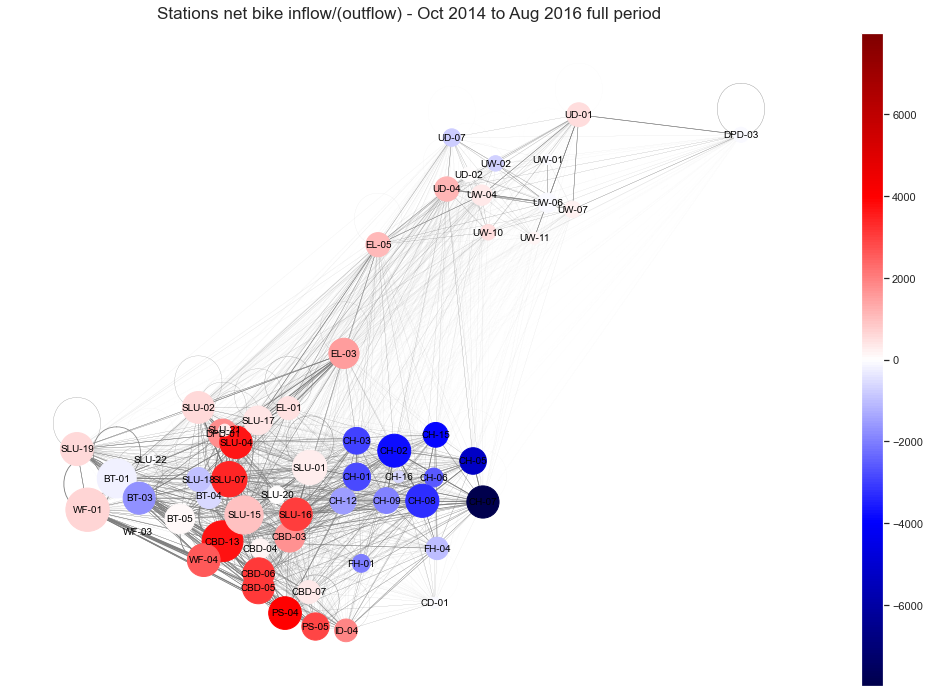

In [94]:
plot_trip_net_flow(G_allyear, df_flow_gp, 'Oct 2014 to Aug 2016 full period')

In [95]:
# top 10 destinations from CH-07, the deepest net outflow station
CH07from = trip_allyear.loc[trip_allyear.from_station_id.isin(['CH-07'])].sort_values(by='nbr_of_trips',ascending=False).iloc[0:10] 
CH07from

from_station_id to_station_id  nbr_of_trips  adj_nbr_of_trips
889           CH-07        SLU-16          1040             1.040
864           CH-07         CH-02           944             0.944
884           CH-07        SLU-01           749             0.749
861           CH-07        CBD-13           725             0.725
866           CH-07         CH-05           712             0.712
869           CH-07         CH-08           459             0.459
856           CH-07        CBD-03           446             0.446
887           CH-07        SLU-07           418             0.418
882           CH-07         PS-04           393             0.393
870           CH-07         CH-09           386             0.386

In [96]:
# top10 stations going to CH-07
CH07to = trip_allyear.loc[trip_allyear.to_station_id.isin(['CH-07'])].sort_values(by='nbr_of_trips',ascending=False).iloc[0:10] 
CH07to

from_station_id to_station_id  nbr_of_trips  adj_nbr_of_trips
757            CH-05         CH-07           653             0.653
644            CH-02         CH-07           489             0.489
868            CH-07         CH-07           289             0.289
1089           CH-15         CH-07           230             0.230
925            CH-08         CH-07           143             0.143
981            CH-09         CH-07           138             0.138
1978          SLU-16         CH-07           131             0.131
1550           ID-04         CH-07           130             0.130
1451           FH-01         CH-07            84             0.084
490           CBD-13         CH-07            72             0.072

###  A specific month - May 2015

In [97]:
# setup network

# whole month
trip_201505 = trip.loc[trip.month.isin(['2015-05'])]
trip_201505g = trip_201505.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
add_col_adj_nbr_of_trips_revised(trip_201505g)
Graph_201505 = nx.from_pandas_edgelist(df=trip_201505g, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_201505)

# weekdays only
trip_201505weekday = trip_201505.loc[trip_201505.week.isin(['weekday'])]
trip_201505weekdayg = trip_201505weekday.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
add_col_adj_nbr_of_trips_revised(trip_201505weekdayg)
Graph_201505weekday = nx.from_pandas_edgelist(df=trip_201505g, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_201505weekday)

# weekends only
trip_201505weekend = trip_201505.loc[trip_201505.week.isin(['weekend'])]
trip_201505weekendg = trip_201505weekend.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
add_col_adj_nbr_of_trips_revised(trip_201505weekendg)
Graph_201505weekend = nx.from_pandas_edgelist(df=trip_201505weekendg, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_201505weekend)


DiGraph with 51 nodes and 1619 edges
DiGraph with 51 nodes and 1619 edges
DiGraph with 51 nodes and 1140 edges


In [98]:
# setup net flow summary
df_flow['month'] = df_flow['date'].dt.strftime('%Y-%m')
df_flow['day_of_week'] = df_flow['date'].apply(lambda x: x.weekday()+1) #1-7 representing Mon to Sun
df_flow['week'] = np.where(df_flow['day_of_week'] < 6, 'weekday', 'weekend')

df_flow_2015May = df_flow.loc[(df_flow['month'].isin(['2015-05']))]
df_flow_2015May = df_flow_2015May.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()

df_flow_2015May_weekday = df_flow.loc[(df_flow['month'].isin(['2015-05']) & df_flow['week'].isin(['weekday']))]
df_flow_2015May_weekday = df_flow_2015May_weekday.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()

df_flow_2015May_weekend = df_flow.loc[(df_flow['month'].isin(['2015-05']) & df_flow['week'].isin(['weekend']))]
df_flow_2015May_weekend = df_flow_2015May_weekend.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()

df_flow_2015May_weekend

station  net_in_out_flow
0    BT-01              1.0
1    BT-03            -59.0
2    BT-04             -5.0
3    BT-05             26.0
4   CBD-03             18.0
5   CBD-05             30.0
6   CBD-06             18.0
7   CBD-07             -4.0
8   CBD-13             43.0
9    CD-01             -2.0
10   CH-01            -34.0
11   CH-02            -42.0
12   CH-03            -16.0
13   CH-05            -61.0
14   CH-06            -30.0
15   CH-07            -78.0
16   CH-08            -38.0
17   CH-09            -41.0
18   CH-12            -31.0
19   CH-15            -44.0
20  DPD-01              4.0
21  DPD-03              8.0
22   EL-01              1.0
23   EL-03              8.0
24   EL-05              8.0
25   FH-01            -43.0
26   FH-04             18.0
27   ID-04             26.0
28   PS-04             66.0
29   PS-05             60.0
30  SLU-01            -16.0
31  SLU-02              7.0
32  SLU-04            -11.0
33  SLU-07             21.0
34  SLU-15             25.0
35  SLU-16             23.0
36  SLU-17             10.0
37  SLU-18             11.0
38  SLU-19             -3.0
39   UD-01             23.0
40   UD-02             -7.0
41   UD-04             19.0
42   UD-07             -6.0
43   UW-01             14.0
44   UW-02            -27.0
45   UW-04              1.0
46   UW-06            -13.0
47   UW-07              1.0
48   UW-10             11.0
49   WF-01             49.0
50   WF-04             61.0

In [99]:
min(df_flow_2015May['net_in_out_flow'].astype(int).to_list())

-381

In [100]:
max(df_flow_2015May['net_in_out_flow'].astype(int).to_list())

218

In [101]:
def plot_trip_net_flow_selectedmo(G, dataframe, title):
    
    # Define which netflow dataframe to plot
    df = dataframe
    df = df.set_index('station')
    df = df.reindex(G.nodes())
    
    # Figure
    fig, ax = plt.subplots(figsize=(18,12))

    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = df['net_in_out_flow'].astype(int).to_list()

    # for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')  
    
    # for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))
    
    # Color scale
    cmap=plt.cm.seismic
    #vmin = min(node_color)
    #vmax = abs(vmin) # balancing the colour bar with middle point at zero
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-380, vmax=380))
    sm._A = []
    plt.colorbar(sm, aspect=30)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=df['net_in_out_flow'].astype(int),cmap="seismic", vmin=-380, vmax=380, alpha=1, node_size= [v*100 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='black', style ="solid", alpha=1, arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='black')

    # Labeling Axes
    ax.set_title('Stations net bike inflow/(outflow) - ' + str(title), fontdict={"fontsize":18}, pad = 15)
    ax.axis('off')

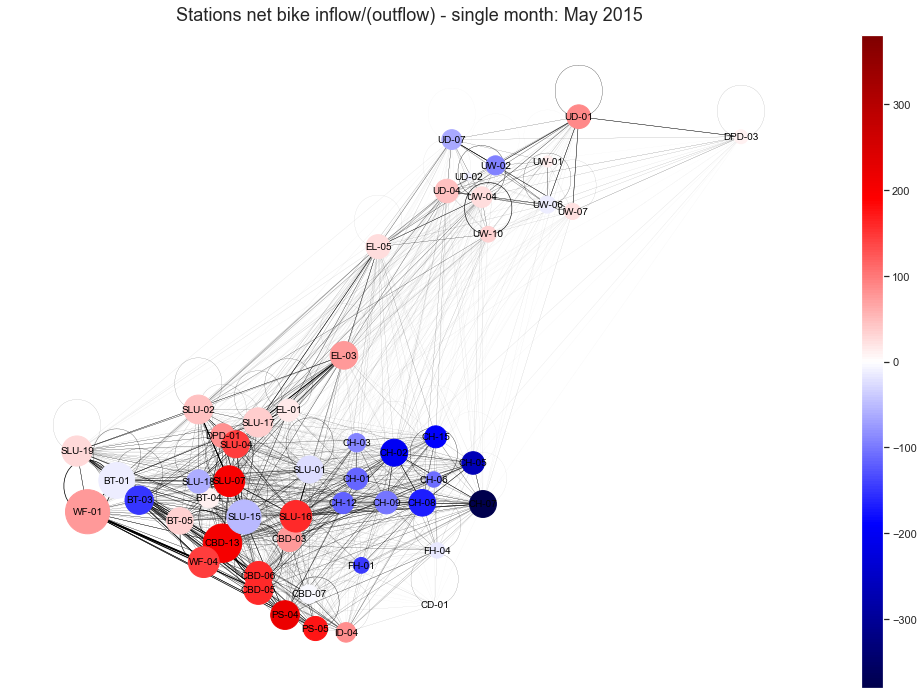

In [102]:
plot_trip_net_flow_selectedmo(Graph_201505, df_flow_2015May, 'single month: May 2015')

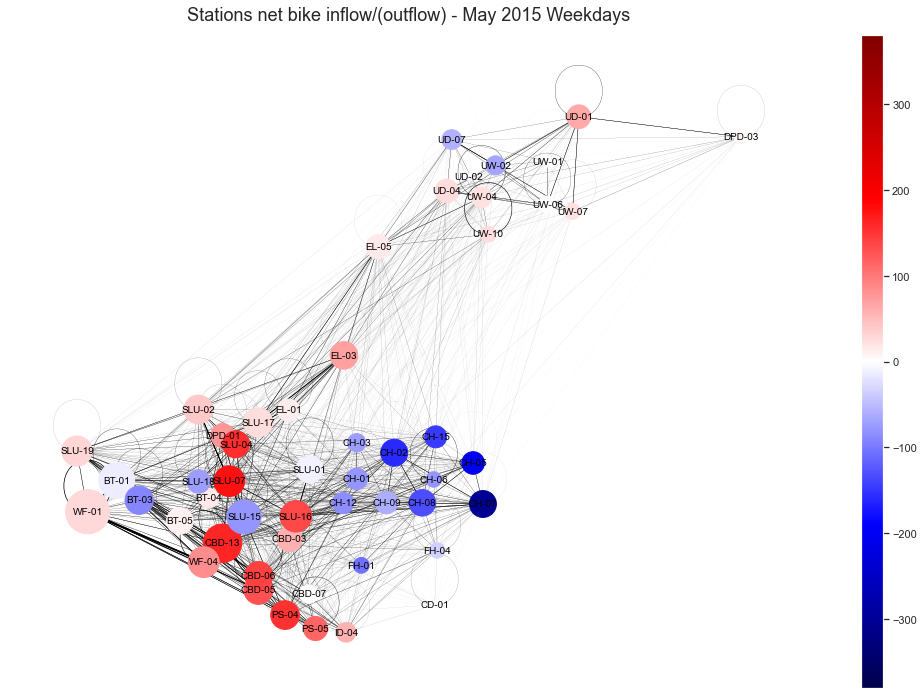

In [103]:
plot_trip_net_flow_selectedmo(Graph_201505weekday, df_flow_2015May_weekday, 'May 2015 Weekdays')

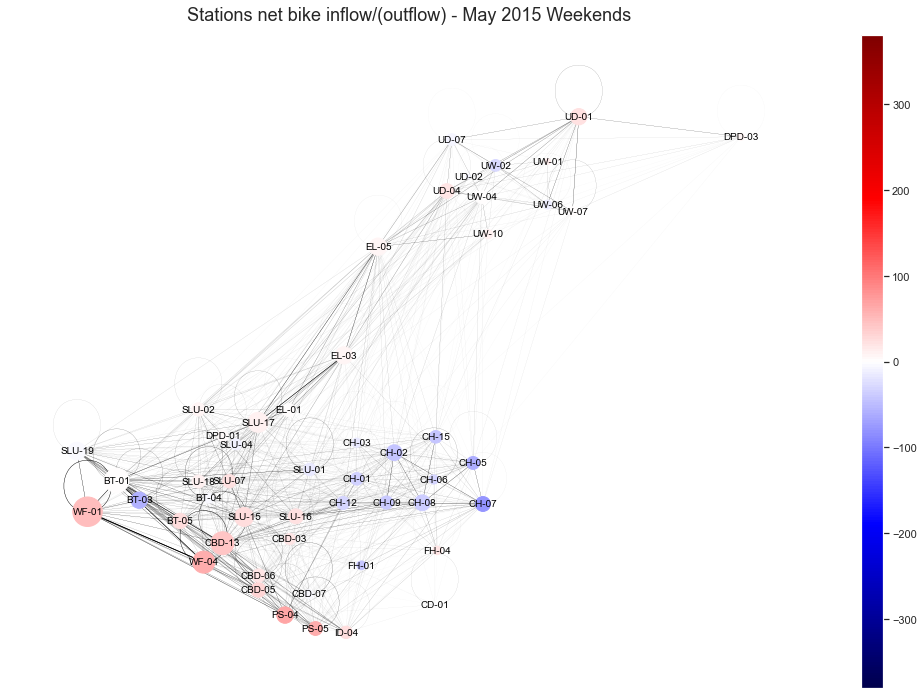

In [104]:
plot_trip_net_flow_selectedmo(Graph_201505weekend, df_flow_2015May_weekend, 'May 2015 Weekends')

### A specific day - May 20, 2015

In [105]:
# setup network
trip_2015_05_20 = trip.loc[trip.date.isin(['2015-05-20'])]
trip_2015_05_20g = trip_2015_05_20.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_2015_05_20g ['adj_nbr_of_trips'] = trip_2015_05_20g ['nbr_of_trips']/10
Graph_20150520 = nx.from_pandas_edgelist(df=trip_2015_05_20g, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_20150520)

DiGraph with 49 nodes and 359 edges


In [106]:
# setup net flow summary
df_flow_2015_05_20 = df_flow.loc[(df_flow['date'].isin(['2015-05-20']))]
df_flow_2015_05_20 = df_flow_2015_05_20.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()
df_flow_2015_05_20

station  net_in_out_flow
0    BT-01              6.0
1    BT-03             -1.0
2    BT-04              4.0
3    BT-05              2.0
4   CBD-03             12.0
5   CBD-05              7.0
6   CBD-06             18.0
7   CBD-07              1.0
8   CBD-13             14.0
9    CH-01             -5.0
10   CH-02             -9.0
11   CH-03             -2.0
12   CH-05            -14.0
13   CH-06             -3.0
14   CH-07            -18.0
15   CH-08             -3.0
16   CH-09             -4.0
17   CH-12             -4.0
18   CH-15            -11.0
19  DPD-01              4.0
20  DPD-03             -2.0
21   EL-01             -2.0
22   EL-03              0.0
23   EL-05              0.0
24   FH-01             -5.0
25   FH-04             -3.0
26   ID-04              5.0
27   PS-04              5.0
28   PS-05             -1.0
29  SLU-01             -4.0
30  SLU-02              3.0
31  SLU-04              0.0
32  SLU-07              5.0
33  SLU-15             -7.0
34  SLU-16              0.0
35  SLU-17             -1.0
36  SLU-18              0.0
37  SLU-19              2.0
38   UD-01              3.0
39   UD-04              2.0
40   UD-07             -2.0
41   UW-01              2.0
42   UW-02             -4.0
43   UW-04              3.0
44   UW-06              3.0
45   UW-07              2.0
46   UW-10              0.0
47   WF-01              2.0
48   WF-04              0.0

In [107]:
min(df_flow_2015_05_20['net_in_out_flow'].to_list())

-18.0

In [108]:
max(df_flow_2015_05_20['net_in_out_flow'].to_list())

18.0

In [109]:
def plot_trip_net_flow_selectedday(G, dataframe, title):
    
    # Define which netflow dataframe to plot
    df = dataframe
    df = df.set_index('station')
    df = df.reindex(G.nodes())
    
    # Figure
    fig, ax = plt.subplots(figsize=(18,12))

    degree = nx.degree(G, weight='nbr_of_trips')
    node_color = df['net_in_out_flow'].to_list()
    

    # for formatting the edge width based on number of trips, adjusted. if not, the width size would be too large
    widths = nx.get_edge_attributes(G, 'adj_nbr_of_trips')  
    
    # for formatting the node size based on weighted degree
    d = dict(G.degree(weight='adj_nbr_of_trips'))
    
    # Color scale
    cmap=plt.cm.seismic
    #vmin = min(node_color)
    #vmax = abs(vmin) # balancing the colour bar with middle point at zero
    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-18, vmax=18))
    sm1._A = []
    plt.colorbar(sm1, aspect=30)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=pos ,node_color=df['net_in_out_flow'].astype(int),cmap="seismic", vmin=-18, vmax=18, alpha=1, node_size= [v*400 for v in d.values()])
    nx.draw_networkx_edges(G=G, pos=pos ,edge_color='black', style ="solid", alpha=1, arrows=False, width=list(widths.values()))
    nx.draw_networkx_labels(G=G, pos=pos,font_size=10, font_color='black')

    # Labeling Axes
    ax.set_title('Stations net bike inflow/(outflow) - ' + str(title), fontdict={"fontsize":19}, pad = 15)
    ax.axis('off')

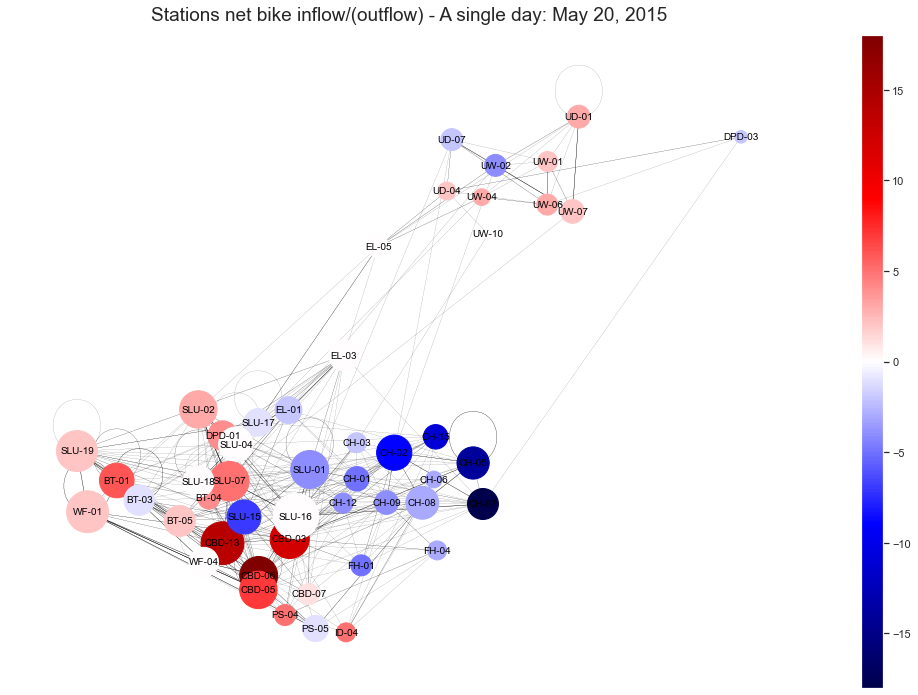

In [110]:
plot_trip_net_flow_selectedday(Graph_20150520, df_flow_2015_05_20, 'A single day: May 20, 2015')

In [111]:
# setup network
trip_2015_05_20_am = trip.loc[trip.date.isin(['2015-05-20']) & trip.pickup_hour.isin([0,1,2,3,4,5,6,7,8,9,10,11])]
trip_2015_05_20_amg = trip_2015_05_20_am.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_2015_05_20_amg ['adj_nbr_of_trips'] = trip_2015_05_20_amg ['nbr_of_trips']/10
Graph_20150520_am = nx.from_pandas_edgelist(df=trip_2015_05_20_amg, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_20150520_am)

trip_2015_05_20_pm = trip.loc[trip.date.isin(['2015-05-20']) & trip.pickup_hour.isin([12,13,14,15,16,17,18,19,20,21,22,23])]
trip_2015_05_20_pmg = trip_2015_05_20_pm.groupby(['from_station_id','to_station_id']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
trip_2015_05_20_pmg ['adj_nbr_of_trips'] = trip_2015_05_20_pmg ['nbr_of_trips']/10
Graph_20150520_pm = nx.from_pandas_edgelist(df=trip_2015_05_20_pmg, source='from_station_id', target='to_station_id', edge_attr=['nbr_of_trips', 'adj_nbr_of_trips'], create_using=nx.DiGraph)
print(Graph_20150520_pm)

DiGraph with 48 nodes and 139 edges
DiGraph with 49 nodes and 247 edges


In [112]:
# setup a netflow dataframe that includes pickup hour
fromdf = trip.groupby(['date', 'pickup_hour', 'from_station_id'])[['trip_id']].count().reset_index()
todf = trip.groupby(['date', 'pickup_hour', 'to_station_id'])[['trip_id']].count().reset_index()
fromdf.rename(columns={'trip_id':'countfrom'}, inplace = True)
todf.rename(columns={'trip_id':'countto'}, inplace = True)

dffromto = pd.merge(fromdf, todf, left_on = ['from_station_id', 'date', 'pickup_hour'], right_on = ['to_station_id', 'date', 'pickup_hour'], how='outer')
dffromto['from_station_id'] = dffromto['from_station_id'].fillna(dffromto['to_station_id']) # outer join caused NaN, just take the station id from the other column
dffromto['countfrom'] = dffromto['countfrom'].fillna(0)
dffromto['countto'] = dffromto['countto'].fillna(0) # also need to fill the NaN with zeros before computation

dffromto['net_in(out)flow'] = dffromto['countto'] - dffromto['countfrom'] # number of trips incoming - outgoing for each station

df_flow = dffromto.drop(['countfrom', 'to_station_id', 'countto'], axis=1)
df_flow.rename(columns={'from_station_id':'station'}, inplace = True)

df_flow

date  pickup_hour station  net_in(out)flow
0      2014-10-13           10  CBD-06            -12.0
1      2014-10-13           11  CBD-05             20.0
2      2014-10-13           11  CBD-07              2.0
3      2014-10-13           11   CH-02             -6.0
4      2014-10-13           11  DPD-01             -2.0
...           ...          ...     ...              ...
235246 2016-08-31           22   CH-03              1.0
235247 2016-08-31           22   PS-04              1.0
235248 2016-08-31           22   WF-03              2.0
235249 2016-08-31           23  CBD-06              1.0
235250 2016-08-31           23   ID-04              4.0

[235251 rows x 4 columns]

In [113]:
# setup net flow summary - am hours
rr = df_flow.loc[(df_flow['date'].isin(['2015-05-20'])) & df_flow['pickup_hour'].isin([0,1,2,3,4,5,6,7,8,9,10,11])]
rr = rr.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()

# setup net flow summary - pm hours
ss = df_flow.loc[(df_flow['date'].isin(['2015-05-20'])) & df_flow['pickup_hour'].isin([12,13,14,15,16,17,18,19,20,21,22,23])]
ss = ss.groupby(['station']).agg(net_in_out_flow = pd.NamedAgg(column = 'net_in(out)flow',aggfunc = 'sum')).reset_index()
ss

station  net_in_out_flow
0    BT-01              5.0
1    BT-03              1.0
2    BT-04              2.0
3    BT-05              2.0
4   CBD-03              5.0
5   CBD-05              8.0
6   CBD-06              4.0
7   CBD-07             -3.0
8   CBD-13              8.0
9    CH-01             -3.0
10   CH-02             -5.0
11   CH-03              4.0
12   CH-05             -4.0
13   CH-06              0.0
14   CH-07             -7.0
15   CH-08             -3.0
16   CH-09             -4.0
17   CH-12             -2.0
18   CH-15             -3.0
19  DPD-01             -1.0
20  DPD-03             -2.0
21   EL-01             -8.0
22   EL-03              0.0
23   EL-05              2.0
24   FH-01             -4.0
25   FH-04              2.0
26   ID-04              4.0
27   PS-04              1.0
28   PS-05              1.0
29  SLU-01             -8.0
30  SLU-02              7.0
31  SLU-04            -10.0
32  SLU-07              0.0
33  SLU-15             -4.0
34  SLU-16              4.0
35  SLU-17              0.0
36  SLU-18              5.0
37  SLU-19              5.0
38   UD-01              0.0
39   UD-04              3.0
40   UD-07              1.0
41   UW-01              2.0
42   UW-02             -3.0
43   UW-04              1.0
44   UW-06              0.0
45   UW-07              3.0
46   UW-10             -1.0
47   WF-01             -3.0
48   WF-04             -2.0

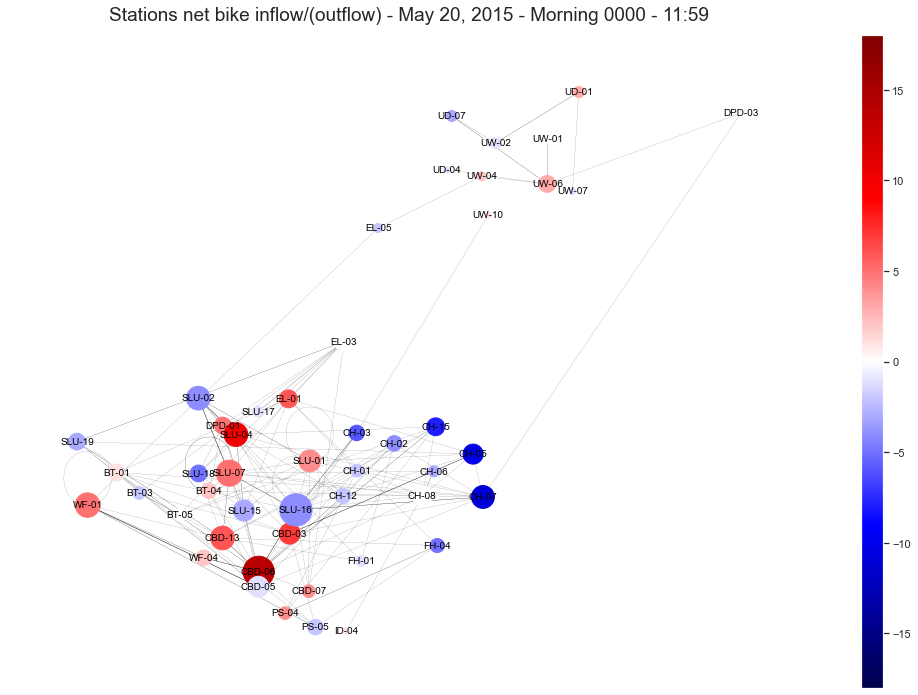

In [114]:
plot_trip_net_flow_selectedday(Graph_20150520_am, rr, 'May 20, 2015 - Morning 0000 - 11:59')

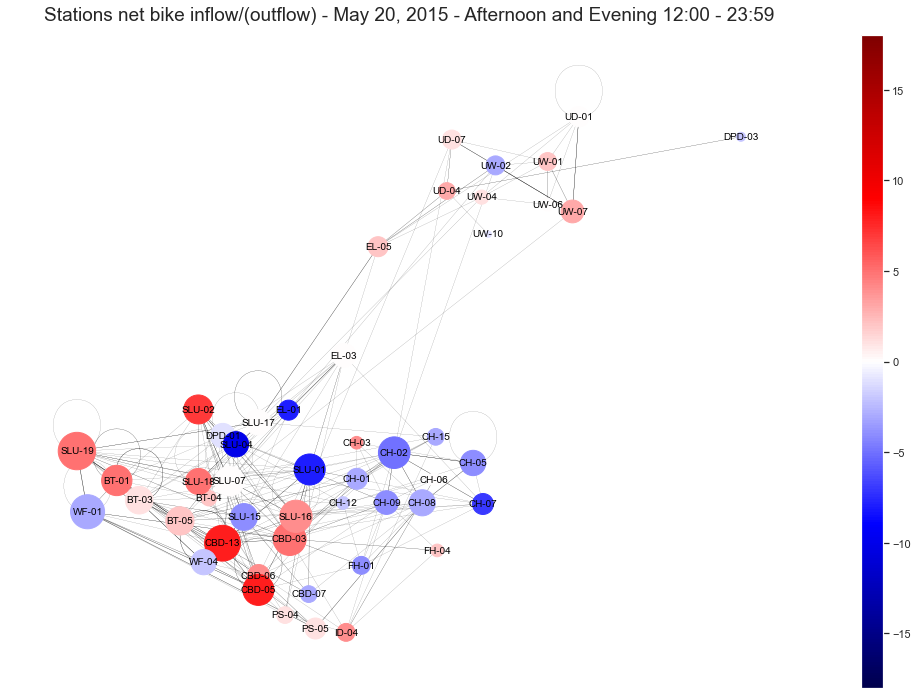

In [115]:
plot_trip_net_flow_selectedday(Graph_20150520_pm, ss, 'May 20, 2015 - Afternoon and Evening 12:00 - 23:59')